In [1]:
import requests
result = requests.get("https://lotr.fandom.com/sitemap-newsitemapxml-index.xml")
c = result.content

In [2]:
from bs4 import BeautifulSoup 
import lxml
import xml.etree.ElementTree as ET
root = ET.fromstring(c)
for link in root.iter('{http://www.sitemaps.org/schemas/sitemap/0.9}loc'):
    print(link.text)

https://lotr.fandom.com/sitemap-newsitemapxml-NS_0-id-2-35626.xml
https://lotr.fandom.com/sitemap-newsitemapxml-NS_0-id-35626-49264.xml
https://lotr.fandom.com/sitemap-newsitemapxml-NS_14-id-21-49203.xml
https://services.fandom.com/discussions-sitemap/sitemap/159


In [3]:
elements = dict()
for page in root.iter('{http://www.sitemaps.org/schemas/sitemap/0.9}loc'):
    result = requests.get(page.text)
    c = result.content
    new_root = ET.fromstring(c)
    for element in new_root.iter('{http://www.sitemaps.org/schemas/sitemap/0.9}loc'):
        elements[element.text.split('/')[-1]] = element.text
print('Found {} elements'.format(len(elements)))

Found 7080 elements


In [4]:
elements['Carolynne_Cunningham']

'https://lotr.fandom.com/wiki/Carolynne_Cunningham'

In [5]:
characters_dict = {}
counter=0
for k,v in elements.items():
    result = requests.get(v)
    c = result.content
    soup = BeautifulSoup(c, "html.parser")  # parse HTML page 
    links = soup.find_all("div", class_='page-header__categories-links')
    try:
        if '/wiki/Category:Characters' in str(links[0]):
            characters_dict[k] = v
            counter+=1
            if counter in range(0,10000,300):
                print('%s added to the dict, dict len: %s' %(k,str(len(characters_dict))))
    except:
        continue

Hallatan added to the dict, dict len: 300
Prisca_(Baggins)_Bolger added to the dict, dict len: 600
Barahir_(Fourth_Age) added to the dict, dict len: 900


In [6]:
category_dict={}
for k,v in characters_dict.items():
    if 'Category:' in k:
        category_dict[k]=v
        del characters_dict[k]
len(characters_dict)

1112

In [9]:
import itertools
inverted_dict = {v.encode('utf-8'): k for k, v in characters_dict.iteritems()}
dict(itertools.islice(inverted_dict.items(), 0, 4))

{'https://lotr.fandom.com/wiki/Adaldrida_(Bolger)_Brandybuck': 'Adaldrida_(Bolger)_Brandybuck',
 'https://lotr.fandom.com/wiki/N%C3%A1li': 'N%C3%A1li',
 'https://lotr.fandom.com/wiki/Ondoher': 'Ondoher',
 'https://lotr.fandom.com/wiki/Thorin_II_Oakenshield': 'Thorin_II_Oakenshield'}

In [8]:
import collections
from lxml import html
import pandas as pd
character_count=collections.Counter()
character_text=dict()
character_network = collections.Counter()
base_url = 'https://lotr.fandom.com'

characters_details=[]

for character_url, character_name in inverted_dict.items():
    character_html = requests.get(character_url)
    page = html.fromstring(character_html.text)
    soup = BeautifulSoup(character_html.content, "html.parser")
        
    lotr_dict={'character_name':character_name,'character_url': character_url}
    lotr_name = soup.find("h2", class_="pi-item pi-item-spacing pi-title")
    if lotr_name:
        lotr_dict['lotr_name']=lotr_name.contents[0]
    for lotr in soup.find_all("div", class_="pi-item"):
        lotr_data = lotr.text.split('\n')
        lotr_dict[lotr_data[1].strip().lower()] = lotr_data[2].strip().lower()
    characters_details.append(lotr_dict)
        
    character = {'name':character_name, 'url':character_url, 'html_content':character_html.text }    
    character['text'] = soup.find('div',{'id':'mw-content-text'}).text 
    character['links'] = collections.Counter([inverted_dict[base_url+link.get('href').encode('utf-8')] for link in soup.find('div',{'id':'mw-content-text'}).find_all('a') if link.get('href') and (base_url+str(link.get('href').encode('utf-8'))) in inverted_dict])
    character_count=character_count + character['links']
    character_text[character_name]=soup.find("div",{"id":"mw-content-text"}).text
    for x in character:
        x = character_name
        for y in character['links']:
            character_network[(x, y)] = character['links'][y]
    if len(character_text) in range(0,2000,100):
        print('%s added to the dict, dict len: %s' %(character_name,str(len(character_text))))

Elendur added to the dict, dict len: 100
Borlad added to the dict, dict len: 200
Sigismond_Took added to the dict, dict len: 300
M%C3%ADriel added to the dict, dict len: 400
Idril added to the dict, dict len: 500
Dagor_(sergeant) added to the dict, dict len: 600
Baranor_(Gondor) added to the dict, dict len: 700
Marhari added to the dict, dict len: 800
Laura_(Grubb)_Baggins added to the dict, dict len: 900
Angelica_Baggins added to the dict, dict len: 1000
Arador added to the dict, dict len: 1100


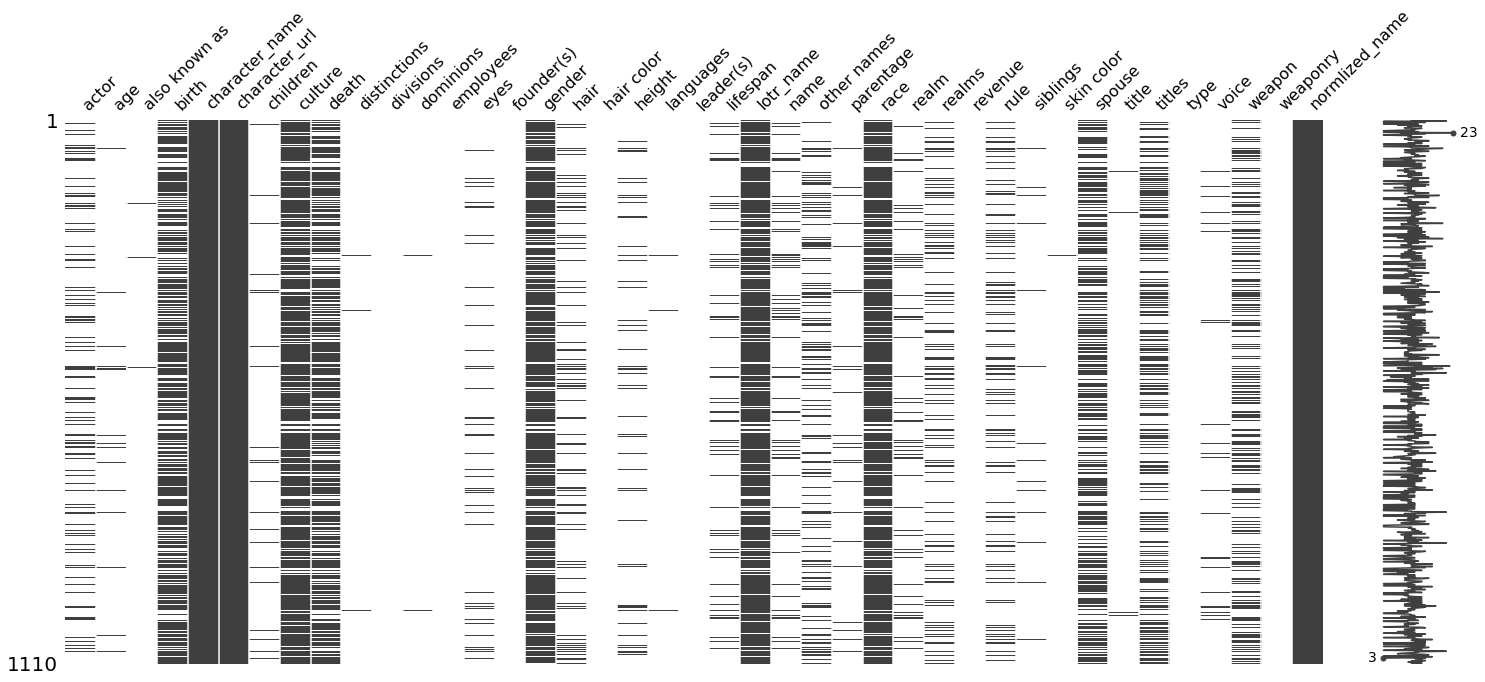

In [16]:
import missingno as msno
characters_details_df = characters_details_df.drop('Unnamed: 0',axis=1)
msno.matrix(characters_details_df)

In [13]:
# characters_details_df.race = characters_details_df.replace()
# characters_details_df.race.value_counts()
# characters_details_df['race'].unique()
characters_details_df['race'] = characters_details_df['race'].replace(
    {"hobbit":"hobbits",
     "elf":"elves",
     "half-elven (elves and maiar)":"half-elven",
     "half-elf": "half-elven",
     "dwarven":"dwarves",
     "dwarf":"dwarves",
     "man":"men",
     "men (skin-changer)": "men",
     "men (originally)": "men",
     "most likely men": "men",
     "men (rohirrim)": "men",
     "man (skin-changer)": "men",
     "man (wraith)": "men",
     "men, later undead": "men",
     "men/wraith": "men",
     "men, later wraith": "men",
     "ent":"ents",
     "ents, onodrim": "ents",
     "dragon":"dragons",
     "eagle": "great eagles",
     "eagles": "great eagles",
     "orc":"orcs",
     "uruk-hai":"orcs",
     "black uruk": "orcs",
     "orcs/goblins":"orcs",
     "orcs; uruk-hai": "orcs",
     "orcs[1]half-trolls": "orcs",
     "uruk": "orcs",
     "black uruk (book)/orc (film)": "orcs",
     "goblin/orc":"orcs",
     "orc/goblin": "orcs",
     "orc (uruk)": "orcs",
     "ainur (maiar)":"ainur",
     "ainur (valar)":"ainur",
     "maiar/balrog": "balrog",
    "troll (olog-hai)": "trolls",
    "stone-trolls": "trolls",
    "unknown, possibly river-spirit": "unknown"})

In [21]:
characters_details_df[characters_details_df['race']=="balrog"].set_index('character_name').drop('normlized_name',axis=1).T.dropna()

character_name,Lungorthin,Tar_Goroth,Gothmog_(Balrog)
character_url,https://lotr.fandom.com/wiki/Lungorthin,https://lotr.fandom.com/wiki/Tar_Goroth,https://lotr.fandom.com/wiki/Gothmog_(Balrog)
culture,valaraukar (balrogs of morgoth),"servants of morgoth, servants of sauron",valaraukar (balrogs of morgoth)
gender,male,male,male
lotr_name,Lungorthin,Tar Goroth,Gothmog
race,balrog,balrog,balrog


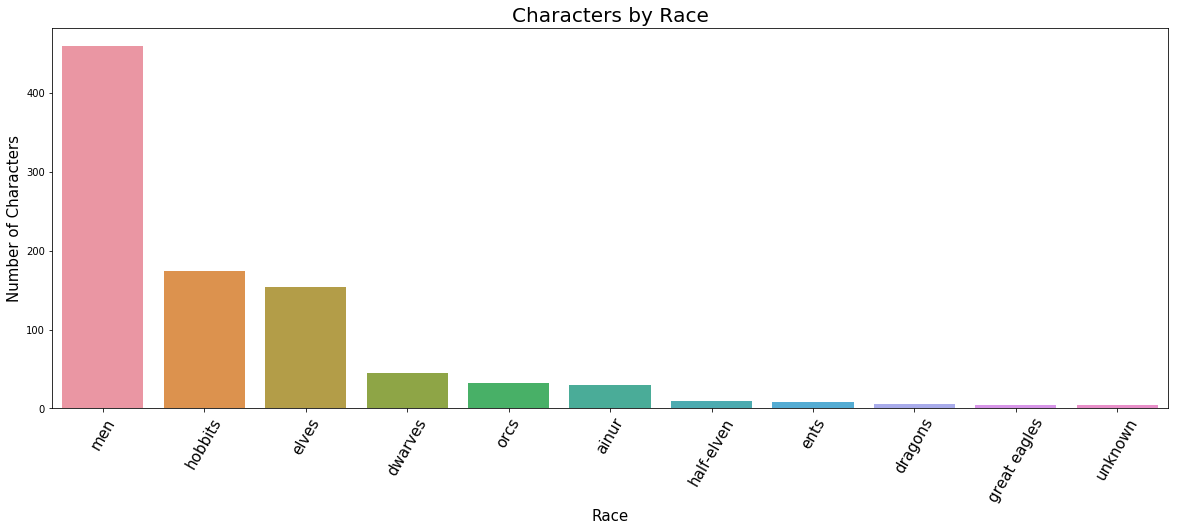

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
sns.countplot(characters_details_df.race,order = characters_details_df.race.value_counts().iloc[:11].index)

plt.xlabel('Race',fontsize=15)
plt.ylabel('Number of Characters',fontsize=15)
plt.title('Characters by Race',fontsize=20)
plt.xticks(rotation=60,fontsize=15)
plt.grid(False)
plt.show()

In [23]:
characters_details_df['normalized_culture'] = characters_details_df['culture'].fillna('unknow')

import urllib
from unidecode import unidecode
def normalized_text(row):

    return unidecode(urllib.unquote_plus(row).decode('utf-8'))

    
characters_details_df['normalized_culture'] = characters_details_df.apply(lambda row: normalized_text(row['normalized_culture']), axis=1)

characters_details_df['normalized_culture'] = characters_details_df['normalized_culture'].replace(
    {"men of gondor (house of hurin)":"men of gondor",
     "rohirrim (house of eorl)":"rohirrim",
     "númenóreans (house of elros)":"numenoreans",
     "shire-hobbits (bolger family)":"shire-hobbits",
     "shire-hobbits (greenhands) ":"shire-hobbits",
     "shire-hobbits (boffin family) ":"shire-hobbits",
     "shire-hobbits (baggins family)":"shire-hobbits",
     "shire-hobbits (took family)":"shire-hobbits",
     "shire-hobbits (boffin family)": "shire-hobbits",
     "men of gondor (house of anarion)":"men of gondor",
     "numenoreans (house of elros)": "house of elros",
     "dunedain of the north (house of isildur)":"house of isildur",
     "silvan elves of lothlorien (galadhrim)": "galadhrim"})

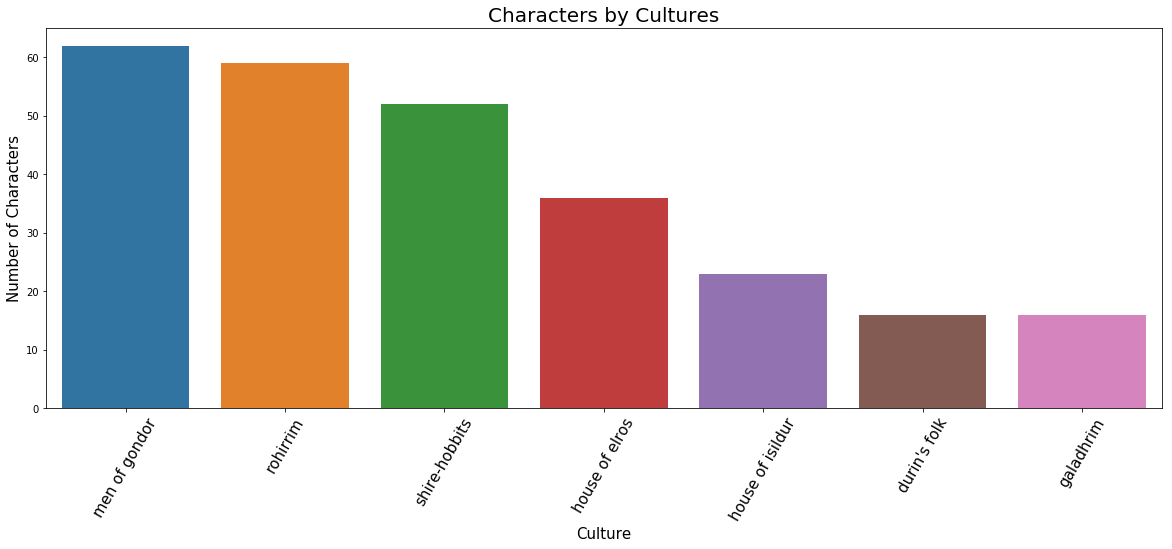

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
sns.countplot(characters_details_df.normalized_culture,order = characters_details_df.normalized_culture.value_counts().iloc[1:8].index)

plt.xlabel('Culture',fontsize=15)
plt.ylabel('Number of Characters',fontsize=15)
plt.title('Characters by Cultures',fontsize=20)
plt.xticks(rotation=60,fontsize=15)
plt.grid(False)
plt.show()

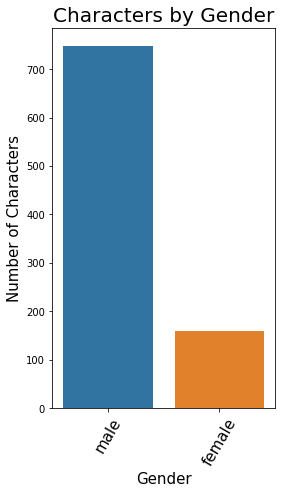

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4,7))
sns.countplot(characters_details_df.gender,order = characters_details_df.gender.value_counts().iloc[:2].index,)

plt.xlabel('Gender',fontsize=15)
plt.ylabel('Number of Characters',fontsize=15)
plt.title('Characters by Gender',fontsize=20)
plt.xticks(rotation=60,fontsize=15)

plt.show()

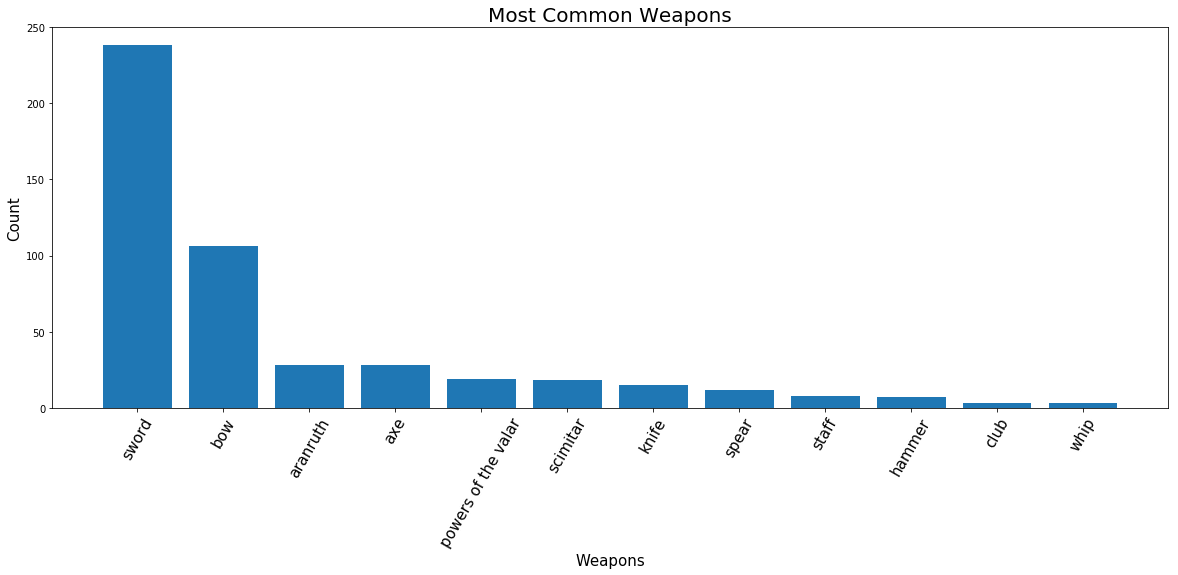

In [26]:
characters_details_df['weapon'] = characters_details_df['weapon'].fillna('unknown')
characters_details_df['normalized_weapon'] = characters_details_df.apply(lambda row: normalized_text(row['weapon']), axis=1)

from collections import OrderedDict
weapon_dict={'sword':0,'bow':0,"powers of the valar":0,"axe":0,
             "staff":0,"spear":0,"hammer":0,"club":0,"knife":0,
             "whip":0, "aranruth":0,"scimitar":0}
for weapon in list(characters_details_df.normalized_weapon.dropna()):
    for k,v in weapon_dict.items():
        if k in weapon:
            weapon_dict[k]+=1
            
weapon_dict = OrderedDict(sorted(weapon_dict.items(), key=lambda x: x[1],reverse=True))
plt.figure(figsize=(20,7))
plt.bar(range(len(weapon_dict)), list(weapon_dict.values()), align='center')
plt.xlabel('Weapons',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Most Common Weapons',fontsize=20)
plt.xticks(range(len(weapon_dict)), list(weapon_dict.keys()),rotation=60,fontsize=15)

plt.show()

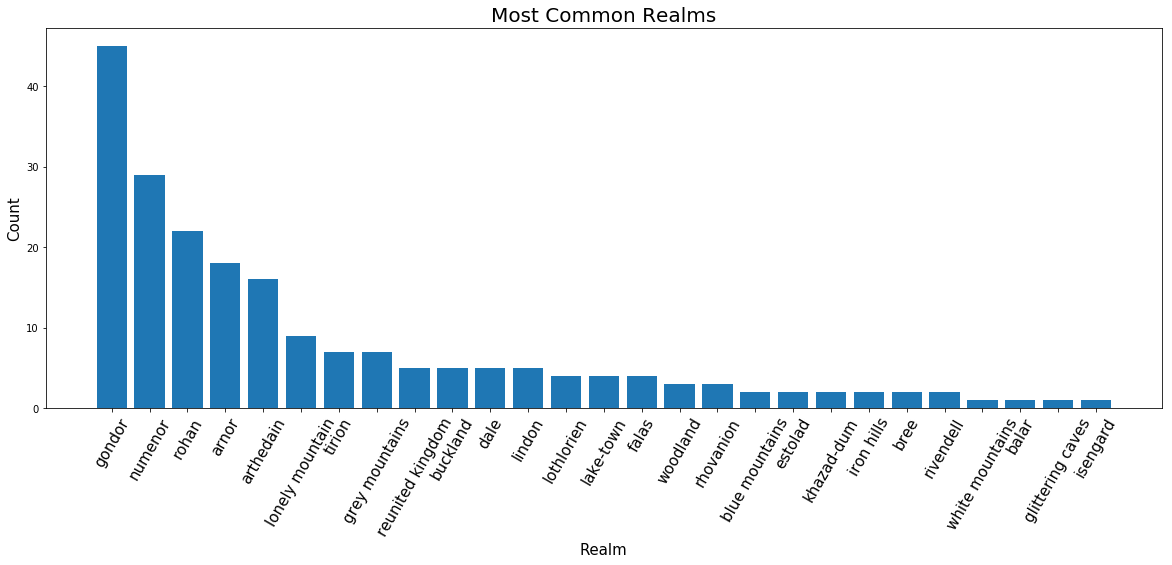

In [27]:
characters_details_df['normalized_realm'] = characters_details_df.apply(lambda row: row['realms'] if pd.isnull(row['realm']) else row['realms'],axis=1)

characters_details_df['normalized_realm'] = characters_details_df.apply(lambda row: normalized_text(row['normalized_realm']) if not pd.isnull(row['normalized_realm']) else row['normalized_realm'],axis=1)

realms_dict={'gondor':0,'numenor':0,"rohan":0,"arthedain":0,"arnor":0,"grey mountains":0,
             "buckland":0,"lake-town":0,"reunited kingdom":0,"tirion":0, "bree":0,"rhovanion":0,
             "dale":0,"estolad":0,"woodland":0,"lonely mountain":0,"iron hills":0,"isengard":0,
             "blue mountains":0,"white mountains":0,"khazad-dum":0,"rivendell":0,"lothlorien":0,
             "glittering caves":0,"falas":0, "balar":0, "lindon":0}

for realm in list(characters_details_df.normalized_realm.dropna()):
    for k,v in realms_dict.items():
        if k in realm:
            realms_dict[k]+=1

realms_dict = OrderedDict(sorted(realms_dict.items(), key=lambda x: x[1],reverse=True))
plt.figure(figsize=(20,7))
plt.bar(range(len(realms_dict)), list(realms_dict.values()), align='center')
plt.xlabel('Realm',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Most Common Realms',fontsize=20)
plt.xticks(range(len(realms_dict)), list(realms_dict.keys()),rotation=60,fontsize=15)
plt.grid(False)
plt.show()

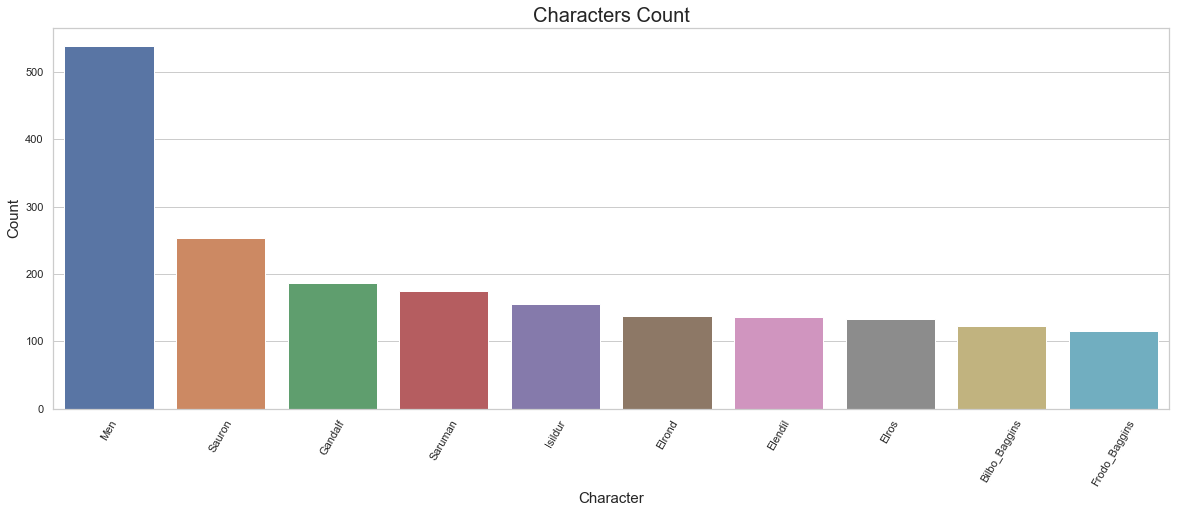

In [28]:
plt.figure(figsize=(20,7))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
character_count_sorted = OrderedDict(sorted(character_count.items(), key=lambda x: x[1],reverse=True))
ax = sns.barplot(x=character_count_sorted.keys()[0:10], y=character_count_sorted.values()[0:10])
plt.title('Characters Count',fontsize=20)
plt.xlabel('Character',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(rotation=60)

plt.show()

In [29]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
char_mask = np.array(Image.open("lotr.jpeg"))  
image_colors = ImageColorGenerator(char_mask)

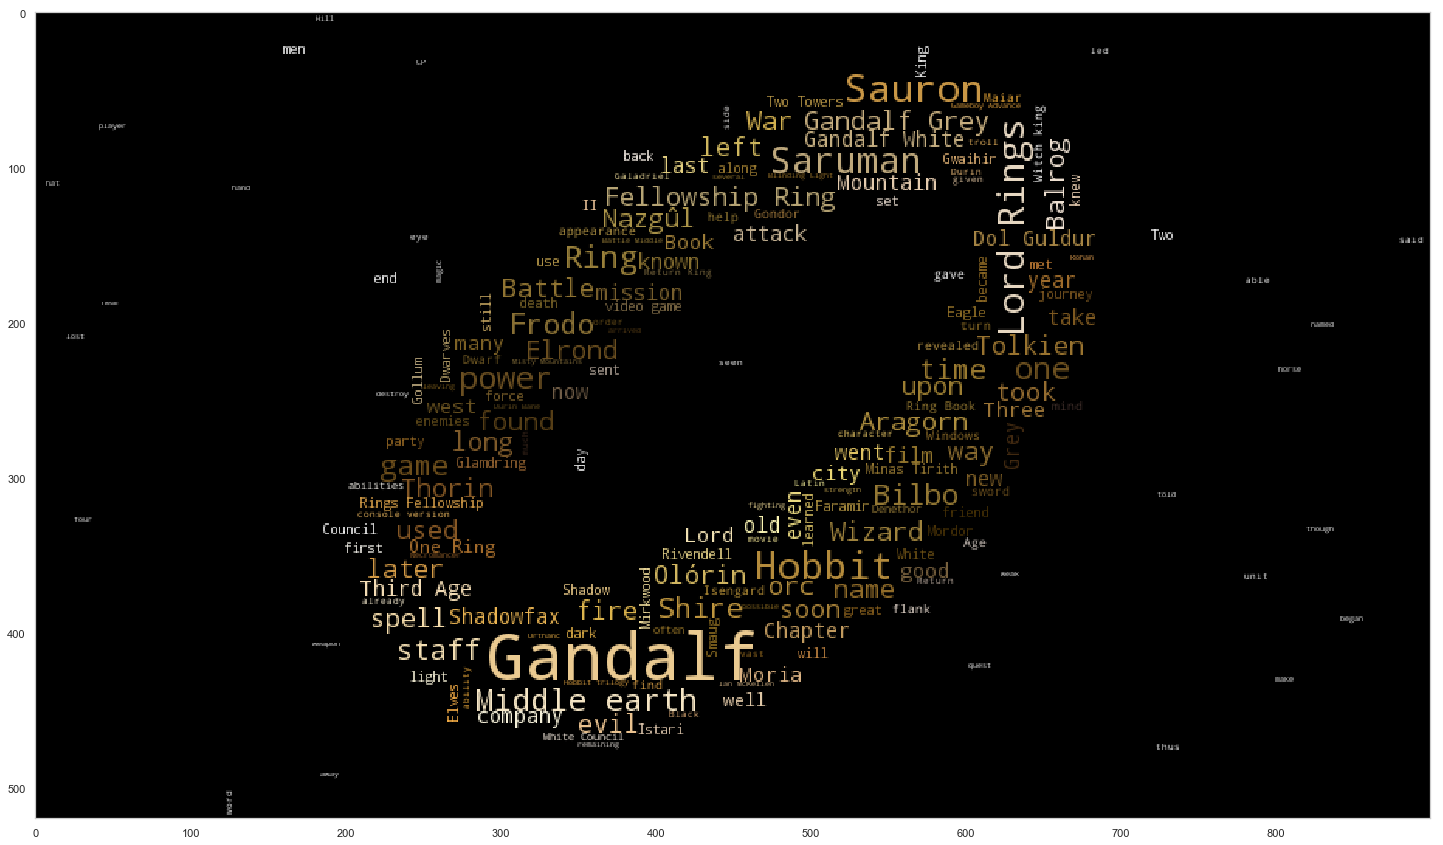

In [30]:
plt.figure(figsize=(25,15))
wc = WordCloud(background_color="black", max_words=200, width=400, height=400, mask=char_mask, random_state=1).generate(character_text['Gandalf'])
plt.imshow(wc.recolor(color_func=image_colors))
plt.grid(False)
plt.show()

In [35]:
from unidecode import unidecode
# unidecode(("aranrúth").decode('utf-8'))

import urllib
from networkx import nx
graph = nx.Graph()
for character, weight in character_network.items():
    if weight>=3:
        graph.add_edge(character[0],character[1], weight=float(weight))
print('Nodes: {0:d}, Links: {1:d}'.format(graph.number_of_nodes(),graph.number_of_edges()))

Nodes: 343, Links: 427


In [36]:
race_dict = pd.Series(characters_details_df.race.values,index=characters_details_df.normlized_name).to_dict()

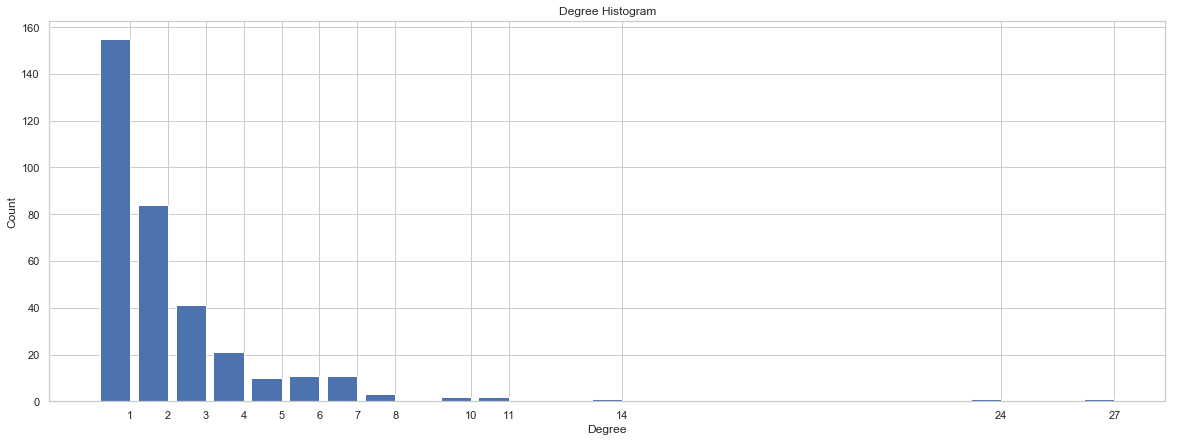

In [37]:
#Degree distribution histogram
import collections
import matplotlib.pyplot as plt
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(20, 7))
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg,)


plt.show()

In [38]:
#Erase nodes with degree lower than 2, for a clearer network 
proceed = True
while proceed: 
    nodes_to_remove =[node for node, degree in graph.degree(graph.nodes) if degree < 2]
    if len(nodes_to_remove)==0:
        proceed = False
    else:
        print('Removing {0:d} nodes'.format(len(nodes_to_remove)))
        graph.remove_nodes_from(nodes_to_remove)
        print('Remaining Nodes: {0:d}, Links: {1:d}'.format(graph.number_of_nodes(),graph.number_of_edges()))

Removing 155 nodes
Remaining Nodes: 188, Links: 297
Removing 42 nodes
Remaining Nodes: 146, Links: 271
Removing 7 nodes
Remaining Nodes: 139, Links: 266
Removing 1 nodes
Remaining Nodes: 138, Links: 265
Removing 1 nodes
Remaining Nodes: 137, Links: 264
Removing 1 nodes
Remaining Nodes: 136, Links: 263
Removing 1 nodes
Remaining Nodes: 135, Links: 262
Removing 1 nodes
Remaining Nodes: 134, Links: 261
Removing 1 nodes
Remaining Nodes: 133, Links: 260
Removing 1 nodes
Remaining Nodes: 132, Links: 259


In [39]:
undirected_graph = graph.to_undirected()
print('Nodes: {0:d}, Links: {1:d}'.format(graph.number_of_nodes(),graph.number_of_edges()))

Nodes: 132, Links: 259


In [40]:
#Degree centrality
node_degree_centrality = nx.degree_centrality(graph)
counter_centrality = collections.Counter(node_degree_centrality)
print (counter_centrality.most_common(10))

[(u'Gandalf', 0.16030534351145037), (u'Sauron', 0.1450381679389313), (u'Frodo_Baggins', 0.09923664122137404), (u'Boromir', 0.08396946564885496), (u'Elrond', 0.08396946564885496), (u'Saruman', 0.07633587786259542), (u'Faramir', 0.06870229007633588), (u'Gollum', 0.061068702290076333), (u'Gimli', 0.05343511450381679), (u'Bilbo_Baggins', 0.05343511450381679)]


In [41]:
network_df = pd.DataFrame(columns=['character','centrality_degree'])
network_df['character'] = counter_centrality.keys()
network_df['centrality_degree'] = counter_centrality.values()
network_df = network_df.sort_values("centrality_degree",ascending=False)
network_df.head()

,character,centrality_degree
44,Gandalf,0.160305
116,Sauron,0.145038
127,Frodo_Baggins,0.099237
22,Boromir,0.083969
55,Elrond,0.083969


In [42]:
network_df['character'] = network_df.apply(lambda row: urllib.unquote_plus(row['character']), axis=1)
network_df.head()

,character,centrality_degree
44,Gandalf,0.160305
116,Sauron,0.145038
127,Frodo_Baggins,0.099237
22,Boromir,0.083969
55,Elrond,0.083969


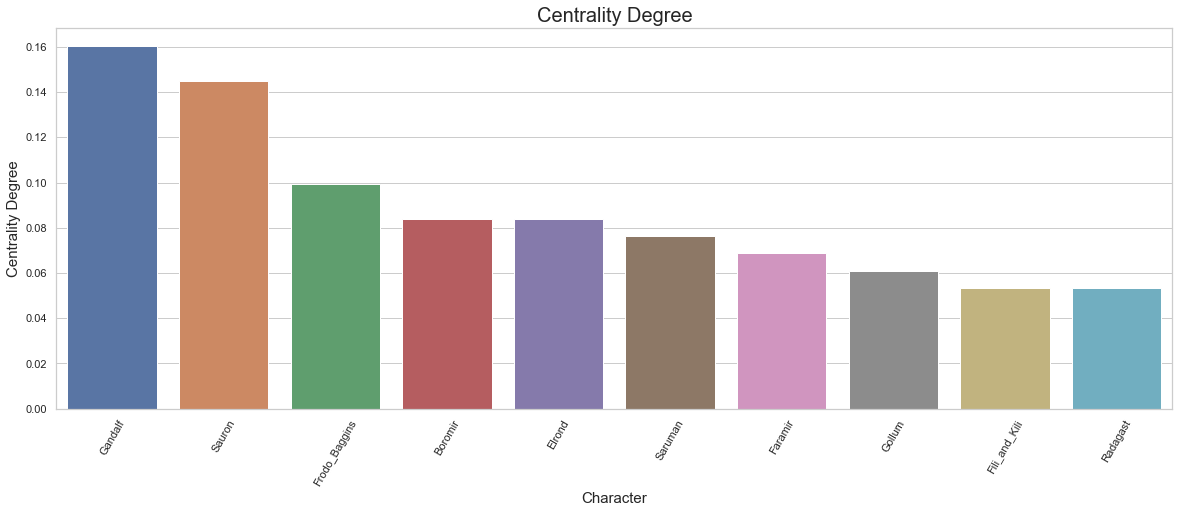

In [43]:
plt.figure(figsize=(20,7))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="character", y="centrality_degree", data=network_df.head(10))
plt.title('Centrality Degree',fontsize=20)
plt.xlabel('Character',fontsize=15)
plt.ylabel('Centrality Degree',fontsize=15)
plt.xticks(rotation=60)

plt.show()

In [44]:
#betweeness centrality
node_betweeness_centrality = nx.algorithms.betweenness_centrality(graph)
counter_betweeness = collections.Counter(node_betweeness_centrality)
print (counter_betweeness.most_common(10))

[(u'Sauron', 0.3031489699104819), (u'Gandalf', 0.2967062184822272), (u'Galadriel', 0.17289365111737387), (u'Elrond', 0.15297025105774373), (u'Feanor', 0.1483972232504235), (u'Melkor', 0.14793974000814872), (u'Bofur', 0.09315662759473949), (u'Fingolfin', 0.09065173588074353), (u'Fili_and_Kili', 0.08320886480531373), (u'Saruman', 0.08070417416616889)]


In [45]:
network_df_betweeness = pd.DataFrame(columns=['character','betweeness_degree'])
network_df_betweeness['character'] = counter_betweeness.keys()
network_df_betweeness['betweeness_degree'] = counter_betweeness.values()
network_df_betweeness = network_df_betweeness.sort_values("betweeness_degree",ascending=False)
network_df_betweeness.head()

,character,betweeness_degree
116,Sauron,0.303149
44,Gandalf,0.296706
0,Galadriel,0.172894
55,Elrond,0.152970
130,Feanor,0.148397


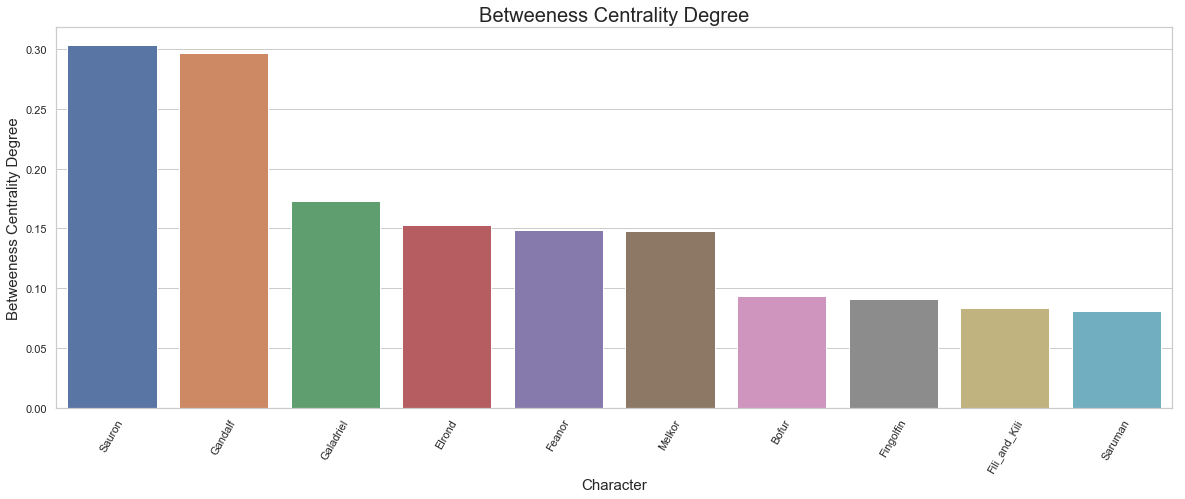

In [46]:
plt.figure(figsize=(20,7))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="character", y="betweeness_degree", data=network_df_betweeness.head(10))
plt.title('Betweeness Centrality Degree',fontsize=20)

plt.xlabel('Character',fontsize=15)
plt.ylabel('Betweeness Centrality Degree',fontsize=15)
plt.xticks(rotation=60)

plt.show()

In [47]:
#Closeness centrality
node_closeness_centrality = nx.closeness_centrality(graph)
counter_closeness_centrality = collections.Counter(node_closeness_centrality)
print (counter_closeness_centrality.most_common(10))

[(u'Sauron', 0.3472604905370613), (u'Gandalf', 0.3372817408089848), (u'Frodo_Baggins', 0.3224561697844141), (u'Elrond', 0.3048676514325369), (u'Saruman', 0.2986616941514675), (u'Galadriel', 0.29790366954702213), (u'Boromir', 0.2941705408559567), (u'Faramir', 0.292703356113533), (u'Gollum', 0.2919752383122555), (u'Radagast', 0.2898124587692018)]


In [48]:
# Pagerank
node_pagerank = nx.algorithms.pagerank(graph)
counter_pagerank = collections.Counter(node_pagerank)
print (counter_pagerank.most_common(10))

[(u'Gandalf', 0.03151257548290906), (u'Sauron', 0.029014951316684856), (u'Frodo_Baggins', 0.020871705717946738), (u'Elrond', 0.020207237864267202), (u'Saruman', 0.019771198298998253), (u'Boromir', 0.015882826263585545), (u'Bofur', 0.013676942287667984), (u'Feanor', 0.012748598676148916), (u'Maglor', 0.012425994785702912), (u'Faramir', 0.012242645482501417)]


In [49]:
# Weighted degree centrality
centrality = {} 
s = 1.0 / (len(graph) - 1.0) 
centrality = {n: d * s for n, d in graph.degree()} 
counter_weighted = collections.Counter(centrality)
print (counter_weighted.most_common(10))

[(u'Gandalf', 0.16030534351145037), (u'Sauron', 0.1450381679389313), (u'Frodo_Baggins', 0.09923664122137404), (u'Boromir', 0.08396946564885496), (u'Elrond', 0.08396946564885496), (u'Saruman', 0.07633587786259542), (u'Faramir', 0.06870229007633588), (u'Gollum', 0.061068702290076333), (u'Gimli', 0.05343511450381679), (u'Bilbo_Baggins', 0.05343511450381679)]


In [50]:
pagerank_list = []
counter_pagerank_2 = counter_pagerank.most_common(100)
for i in counter_pagerank_2:
    pagerank_list.append(i[0])
print (pagerank_list)

[u'Gandalf', u'Sauron', u'Frodo_Baggins', u'Elrond', u'Saruman', u'Boromir', u'Bofur', u'Feanor', u'Maglor', u'Faramir', u'Thror', u'Nerdanel', u'Bilbo_Baggins', u'Gollum', u'Isildur', u'Finwe', u'Bard', u'Thorin_II_Oakenshield', u'Gimli', u'Radagast', u'Melkor', u'Huor', u'Fili_and_Kili', u'Fingolfin', u'Maedhros', u'Vana', u'Eowyn', u'Galadriel', u'Luthien', u'Legolas', u'Beren', u'Turgon', u'Finarfin', u'Alatar', u'Witch-king_of_Angmar', u'Maeglin', u'Aredhel', u'Galador', u'Mithrellas', u'Thrain_II', u'Gil-galad', u'Arvedui', u'Aragorn_II_Elessar', u'Pallando', u'Bergil', u'Beregond_(Captain)', u'Borlas', u'Eonwe', u'Gilmith', u'Imrazor', u'Manwe', u'Hurin', u'Theoden', u'Tuor', u'Elendil', u'Dori', u'Peregrin_Took', u'Meriadoc_Brandybuck', u'Cirdan', u'Celegorm', u'Curufin', u'Balin', u'Frerin', u'Aule', u'Smaug', u'Eomer', u'Arien', u'Finduilas_of_Dol_Amroth', u'Bain', u'Earendil', u'Celeborn', u'Eomund', u'Dis', u'Samwise_Gamgee', u'Rian', u'Dior', u'Fror', u'J.R.R._Tolkien', u'

In [51]:
subgraph = graph.subgraph([name for name in pagerank_list])

In [52]:
# Clustering the characters to communities
import networkx as nx
from networkx.algorithms import community

communities = [comminuity for comminuity in community.label_propagation.label_propagation_communities(subgraph)]
print('Found {0:d} communities using label propagation algorithm'.format(len(communities)))
print(communities)

Found 19 communities using label propagation algorithm
[set([u'Melkor', u'Arien', u'Vana', u'Tulkas', u'Finarfin', u'Nessa', u'Finwe', u'Fingolfin']), set([u'Lothiriel', u'Eomund', u'Eomer', u'Theoden', u'Eowyn']), set([u'Celeborn', u'Pallando', u'Yavanna', u'Galadriel', u'Saruman', u'Gimli', u'Legolas', u'Meriadoc_Brandybuck', u'Samwise_Gamgee', u'Denethor_II', u'Gandalf', u'Peregrin_Took', u'Sauron', u'Gollum', u'Aule', u'Finduilas_of_Dol_Amroth', u'Boromir', u'Faramir', u'Radagast', u'Aragorn_II_Elessar', u'Frodo_Baggins', u'Alatar', u'Witch-king_of_Angmar']), set([u'Earendil', u'Arwen', u'Elendil', u'Elrond', u'Isildur']), set([u'Borlas', u'Beregond_(Captain)', u'Bergil']), set([u'Ilmare', u'Manwe', u'Varda', u'Eonwe']), set([u'Ondoher', u'Firiel', u'Arvedui']), set([u'Huan', u'Orome']), set([u'Bofur', u'Bombur', u'Bifur']), set([u'Imrazor', u'Galador', u'Gilmith', u'Mithrellas']), set([u'Fili_and_Kili', u'Smaug', u'Thorin_II_Oakenshield', u'Frerin', u'Thror', u'Thrain_II', u'Fror'

In [53]:
import matplotlib.pyplot as plt
colors = plt.cm.get_cmap('hsv', len(communities)) # colors(n) will generate a color for community

In [54]:
from IPython.display import HTML, display
import tabulate

table = [ ['community number','names']]
for community_id, community in enumerate(communities):
    table.append([community_id])
    table.append(['',community])
display(HTML(tabulate.tabulate(table, tablefmt='html')))

community number,names
0,
,"set([u'Melkor', u'Arien', u'Vana', u'Tulkas', u'Finarfin', u'Nessa', u'Finwe', u'Fingolfin'])"
1,
,"set([u'Lothiriel', u'Eomund', u'Eomer', u'Theoden', u'Eowyn'])"
2,
,"set([u'Celeborn', u'Pallando', u'Yavanna', u'Galadriel', u'Saruman', u'Gimli', u'Legolas', u'Meriadoc_Brandybuck', u'Samwise_Gamgee', u'Denethor_II', u'Gandalf', u'Peregrin_Took', u'Sauron', u'Gollum', u'Aule', u'Finduilas_of_Dol_Amroth', u'Boromir', u'Faramir', u'Radagast', u'Aragorn_II_Elessar', u'Frodo_Baggins', u'Alatar', u'Witch-king_of_Angmar'])"
3,
,"set([u'Earendil', u'Arwen', u'Elendil', u'Elrond', u'Isildur'])"
4,
,"set([u'Borlas', u'Beregond_(Captain)', u'Bergil'])"


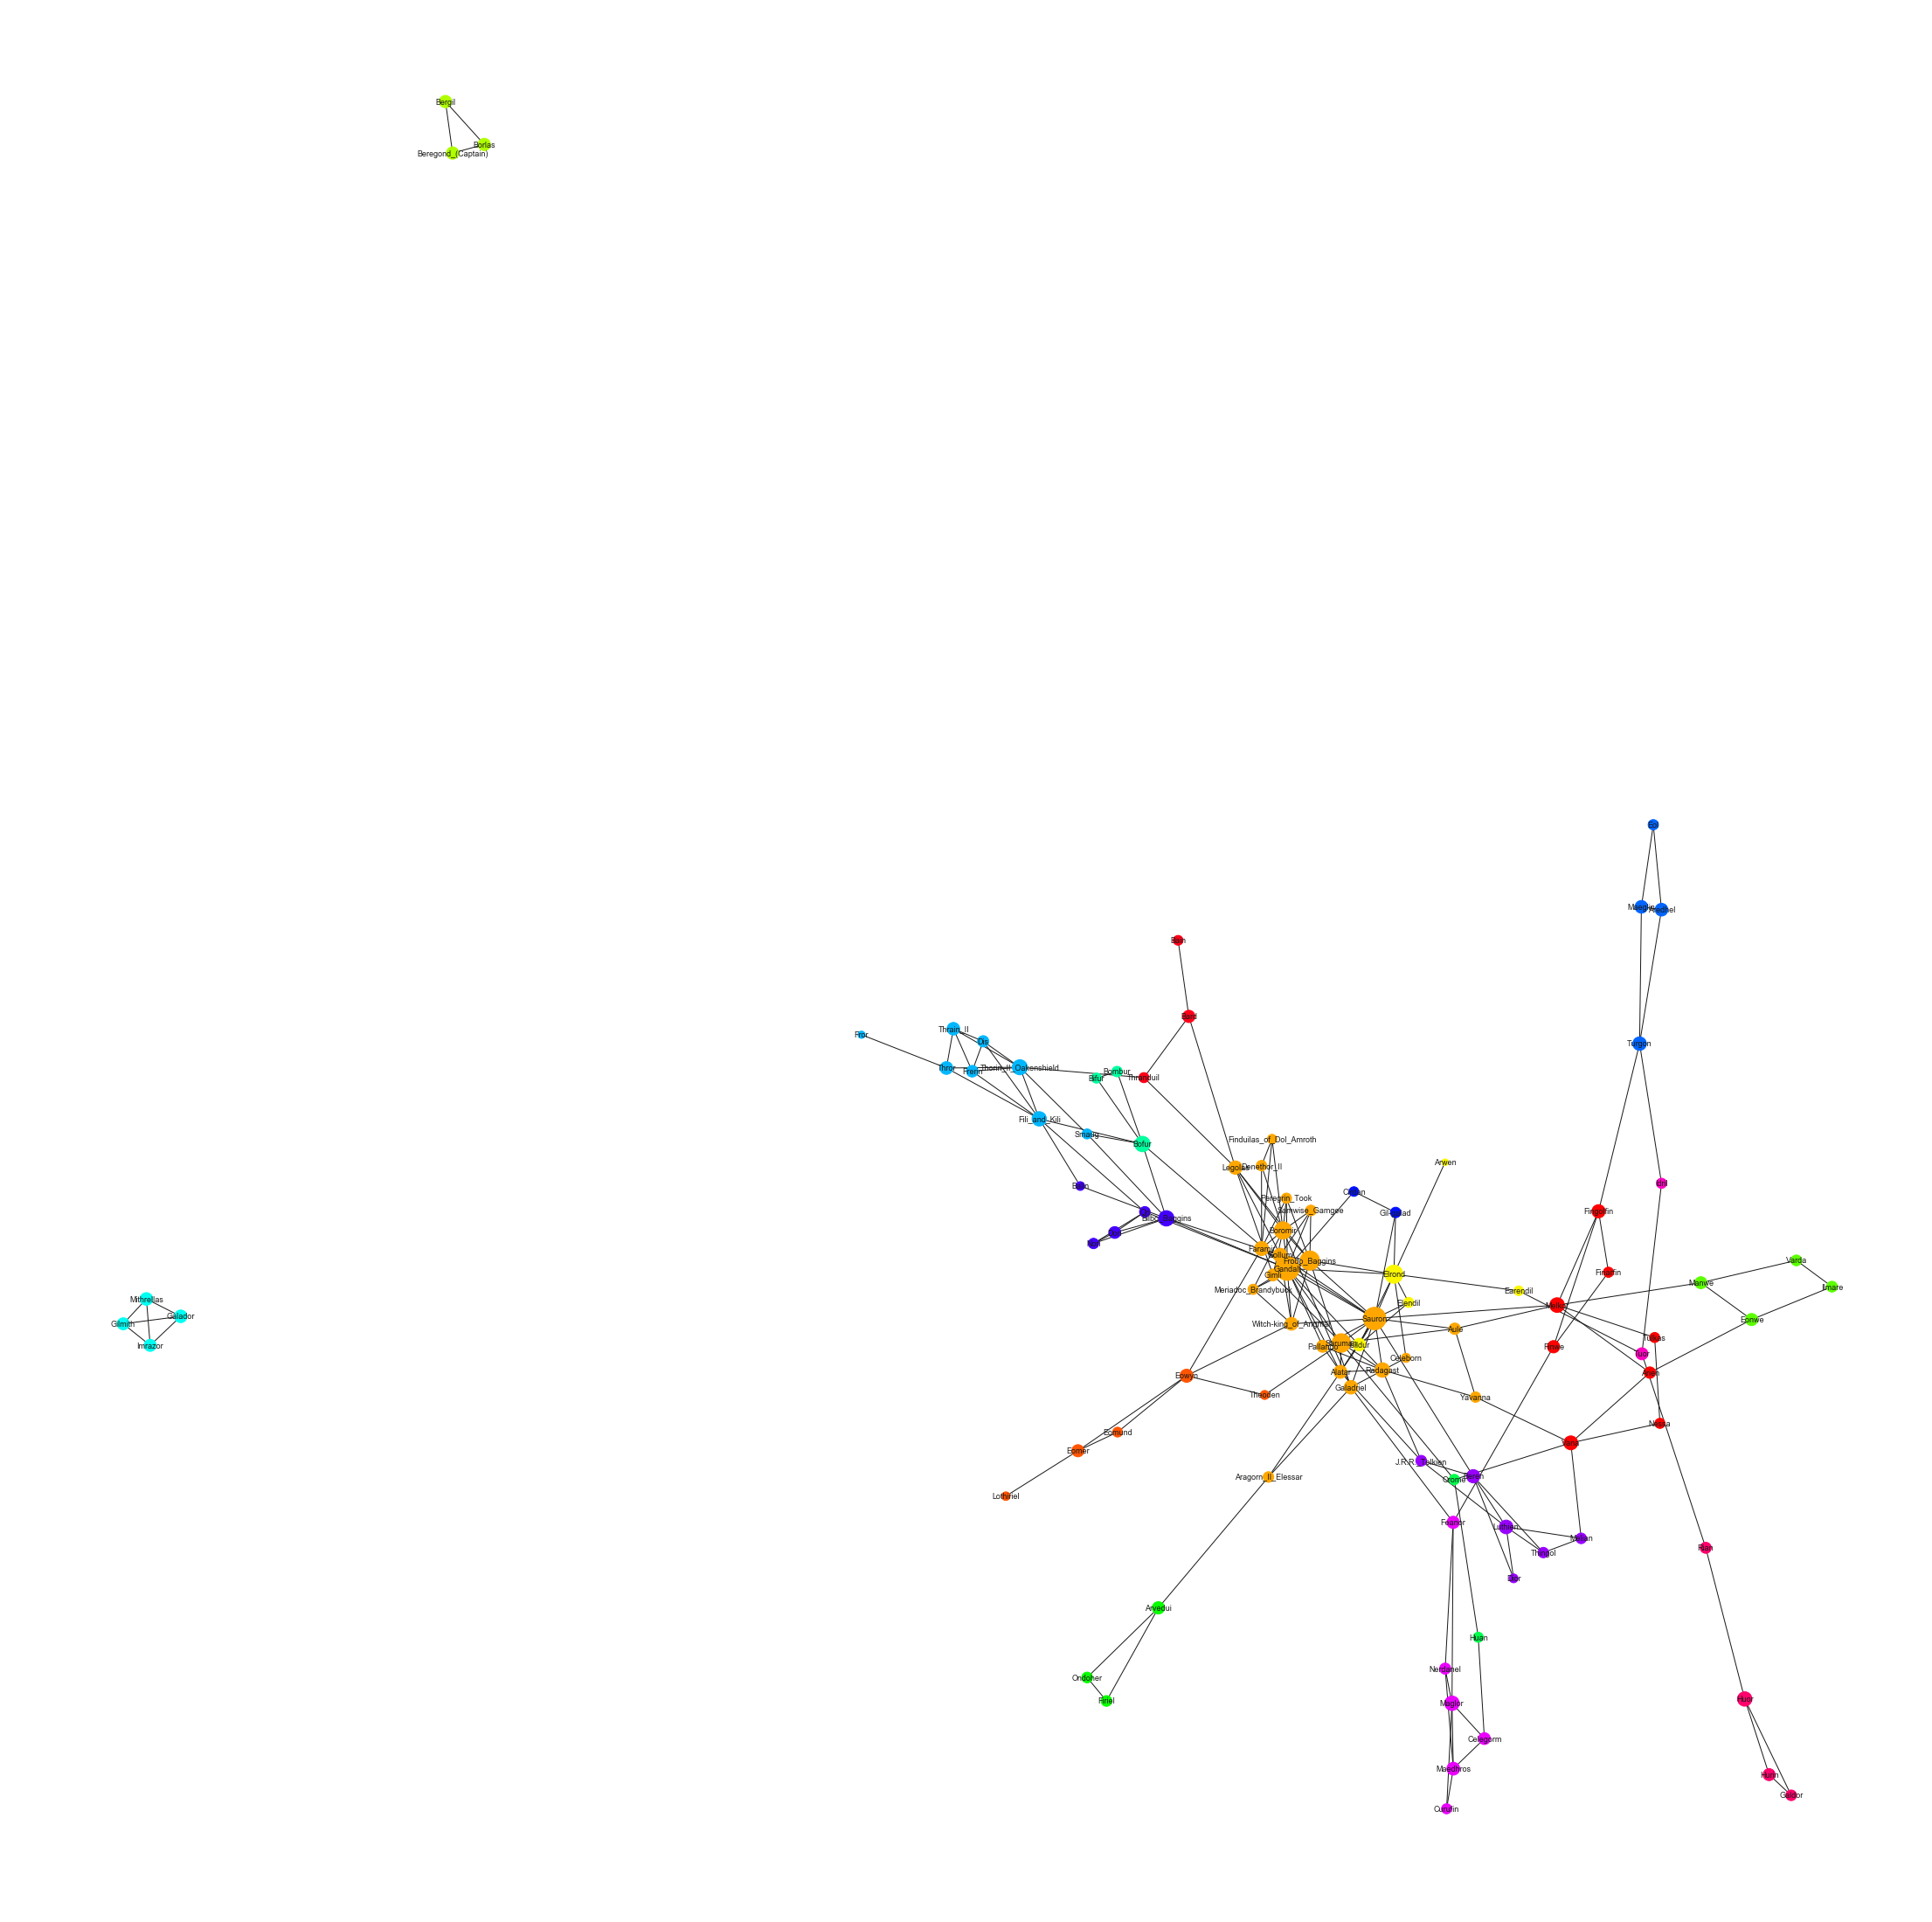

In [55]:
import matplotlib.pyplot as plt


node_pagerank = nx.algorithms.pagerank(subgraph)
node_sizes = []
for node in subgraph.nodes: 
    node_sizes.append(20000*node_pagerank[node])
node_colors = [None]*subgraph.number_of_nodes()
node_names = [node for node in subgraph.nodes]
for community_id, community in enumerate(communities):
    community_color = colors(community_id)
    for node in community:
        node_colors[node_names.index(node)] = community_color
plt.figure(figsize=(30,30))
nx.draw(subgraph, pos=nx.spring_layout(subgraph),node_size=node_sizes,node_color=node_colors, with_labels = True, font_size = 9)
plt.show()

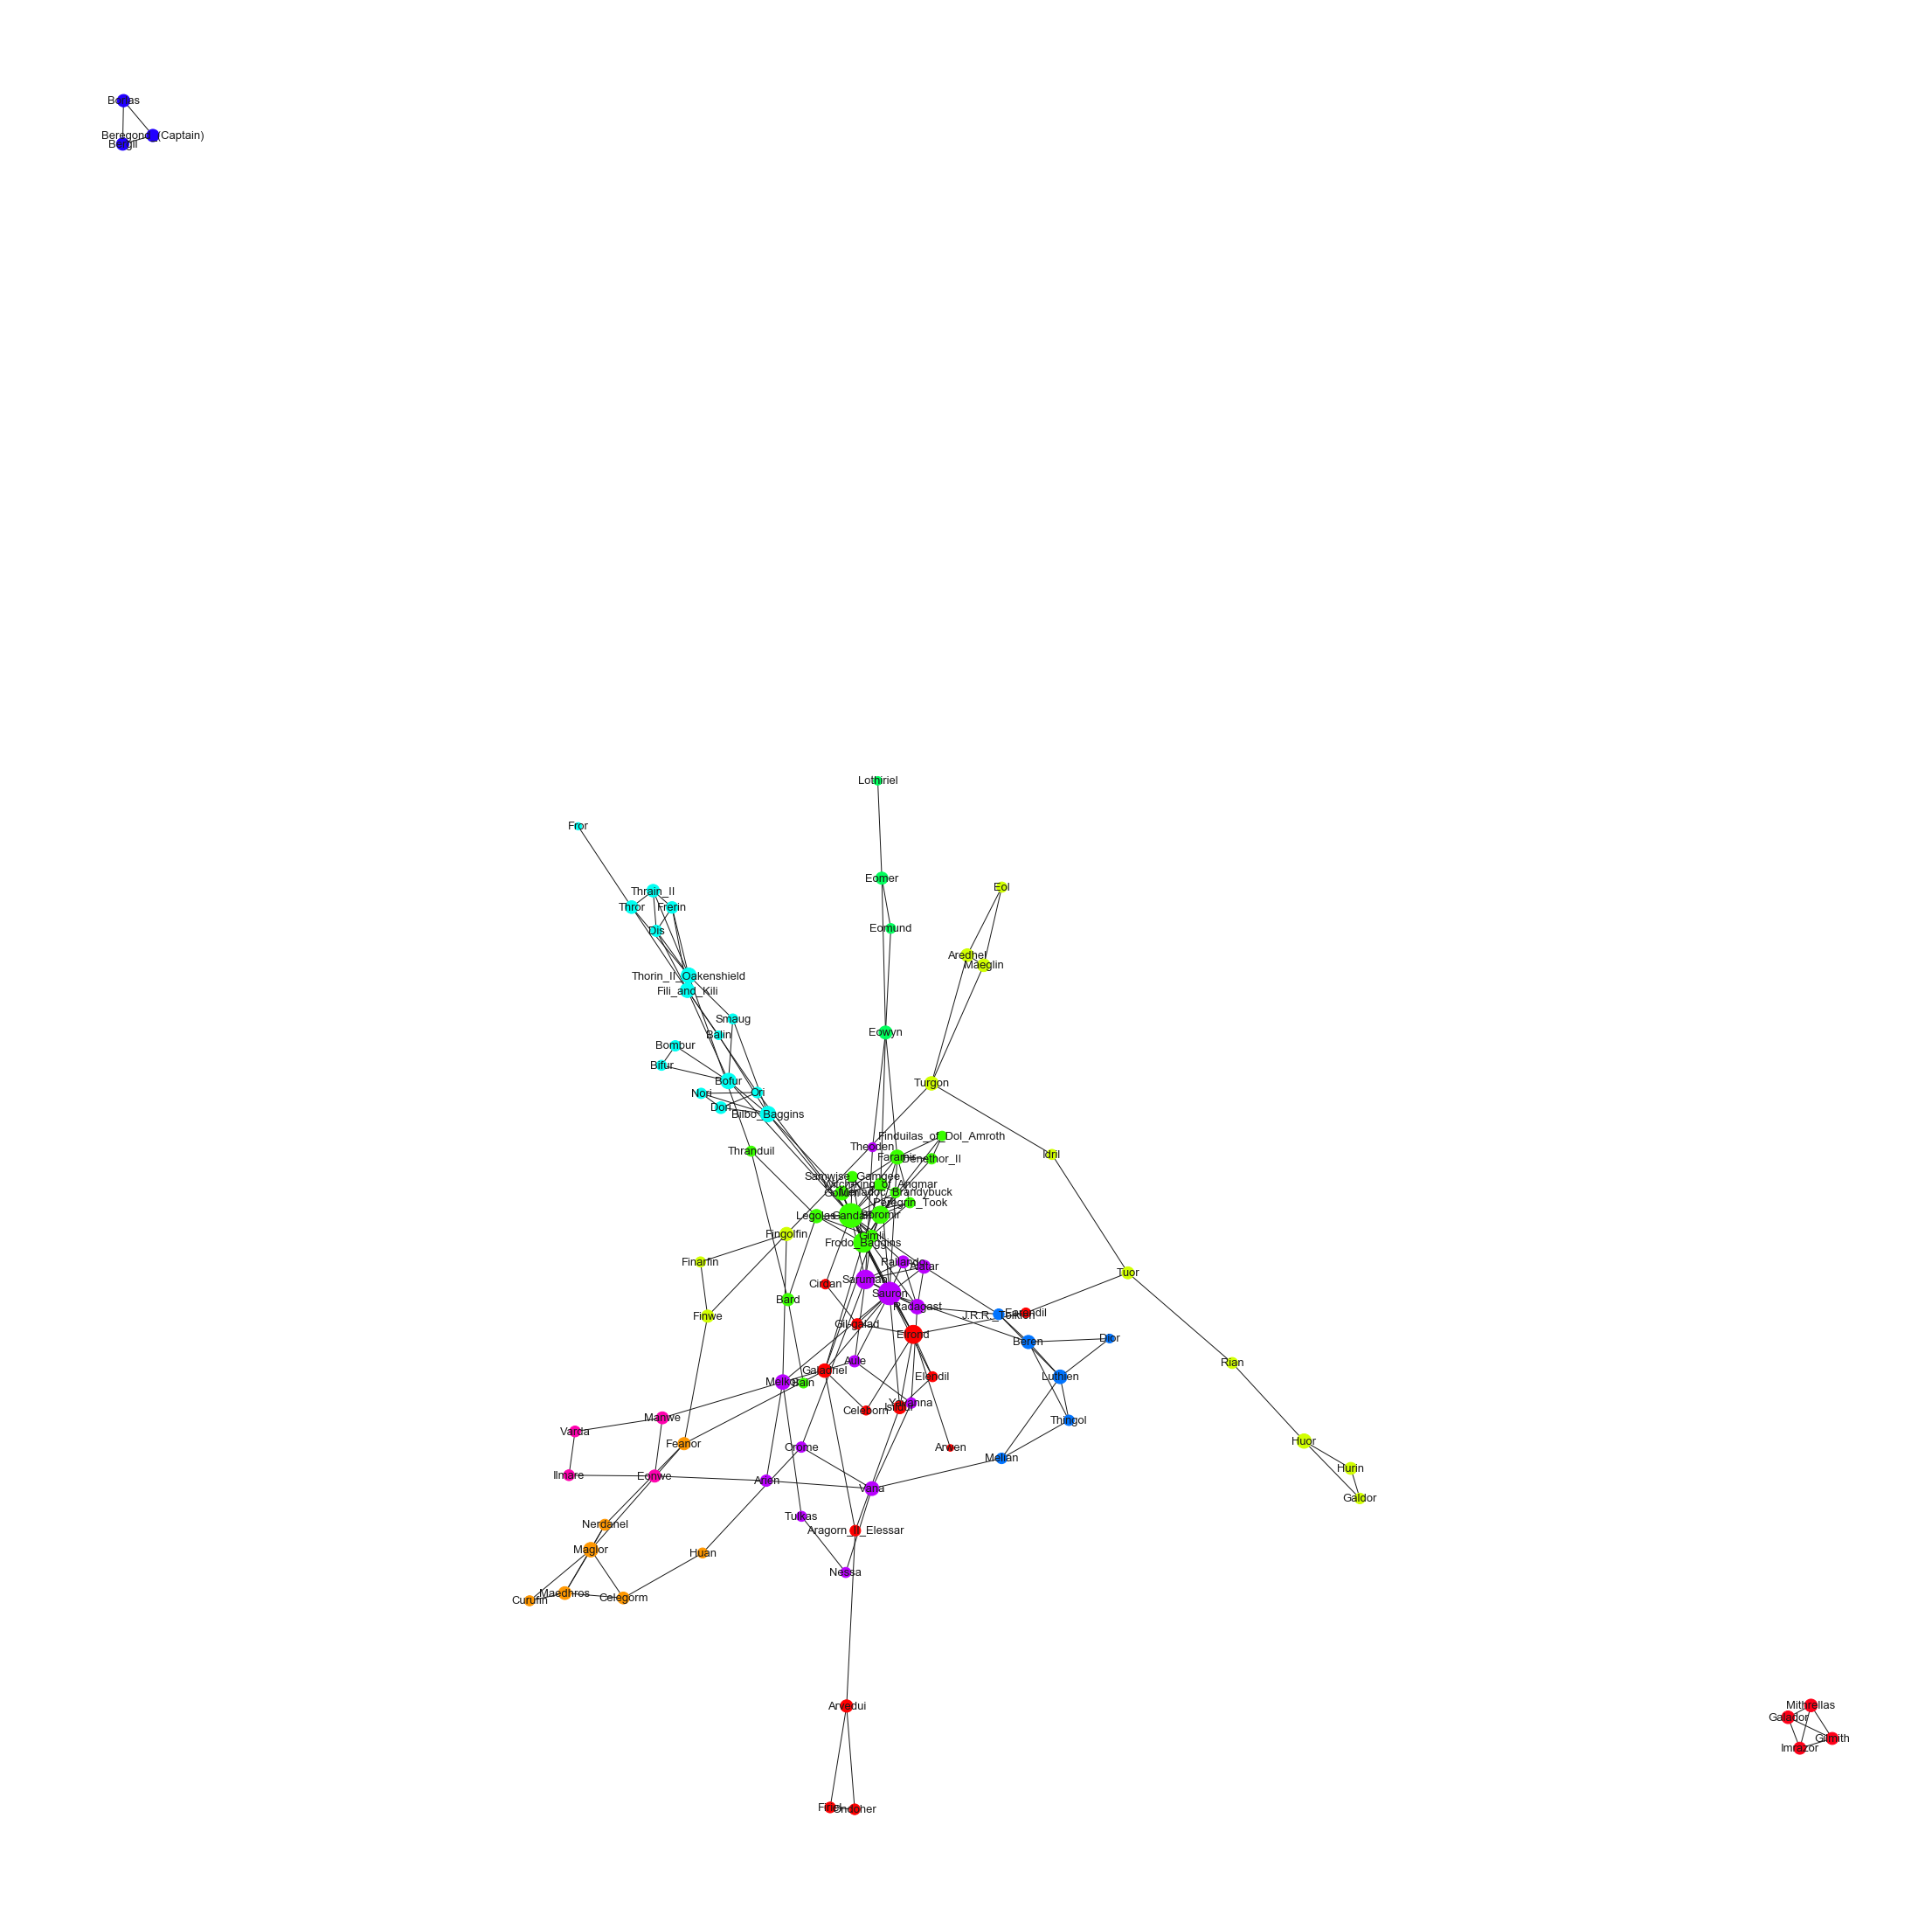

In [56]:
import matplotlib.pyplot as plt
import community
partition = community.best_partition(subgraph)

invers_partition={}
for i in partition.values():
    if i not in invers_partition:
        invers_partition[i]=[]
for k,v in partition.items():
    invers_partition[v].append(k)
invers_partition

lis=[partition]


colors = plt.cm.get_cmap('hsv', len(set(val for partition in lis for val in partition.values()))) # colors(n) will generate a color for community



node_pagerank = nx.algorithms.pagerank(subgraph)
node_sizes = []
for node in subgraph.nodes: 
    node_sizes.append(20000*node_pagerank[node])
node_colors = [None]*subgraph.number_of_nodes()
node_names = [node for node in subgraph.nodes]
for community_id,community_list in invers_partition.items():
    community_color = colors(community_id)
    for node in community_list:
        node_colors[node_names.index(node)] = community_color
plt.figure(figsize=(30,30))
nx.draw(subgraph, pos=nx.spring_layout(subgraph),node_size=node_sizes,node_color=node_colors, with_labels = True, font_size = 13)
plt.show()

In [57]:
character_race = dict()
races_list=list(characters_details_df['race'].value_counts().head(11).index)
for race in races_list:
    temp_df = characters_details_df[['character_name','race']].groupby('race').get_group(race)
    character_race[race] = [i for i in list(temp_df.character_name) if i in list(subgraph.nodes)]
for k,v in character_race.items():
    if v==[]:
        del character_race[k]

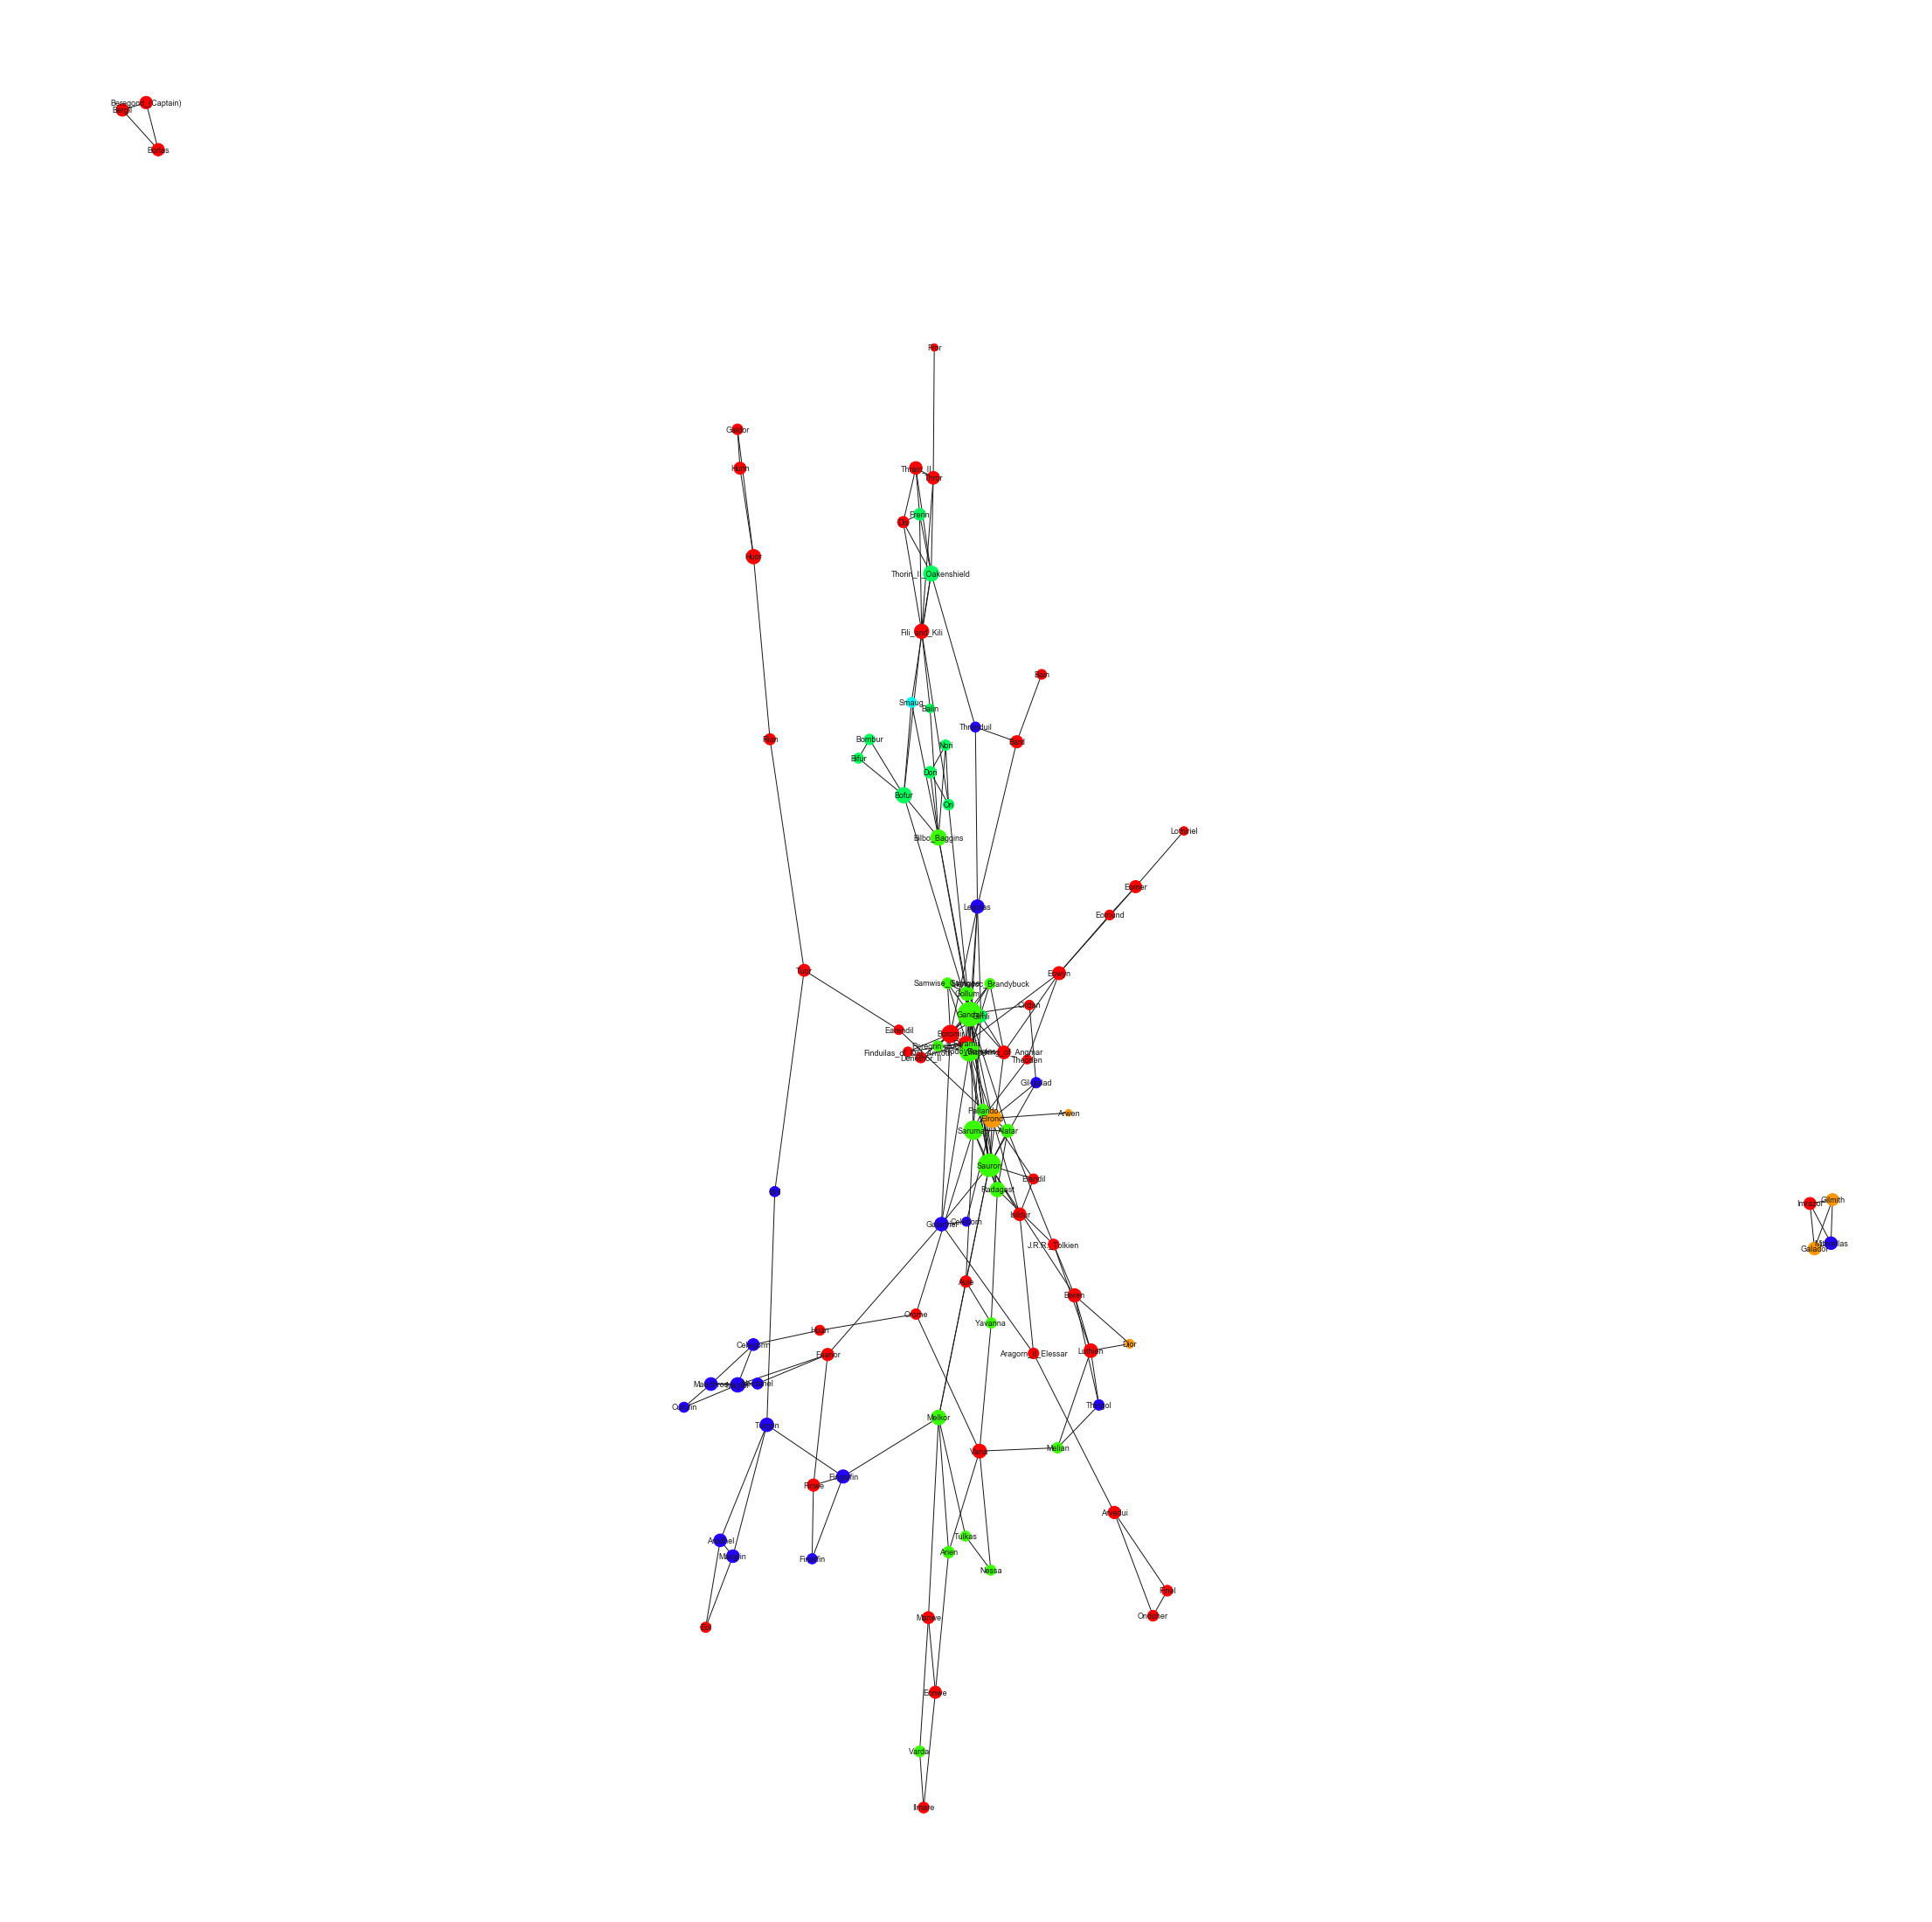

In [59]:

#The more central the node, the bigger its circle is. the nodes are colored according to their culture
import random
import matplotlib.pyplot as plt


node_pagerank = nx.algorithms.pagerank(subgraph)
node_sizes = []
for node in subgraph.nodes: 
    node_sizes.append(20000*node_pagerank[node])
node_colors = [None]*subgraph.number_of_nodes()
for i in range(len(node_colors)):
    if not node_colors[i]:
        node_colors[i]=(1.0, 0.0, 0.0, 1.0)
node_names = [node for node in subgraph.nodes]
for k, v in character_race.items():
    culture_color = colors(random.random()) #create color for culture
    for node in v:
        node_colors[node_names.index(node)] = culture_color
plt.figure(figsize=(30,30))
nx.draw(subgraph, pos=nx.spring_layout(subgraph),node_size=node_sizes,node_color=node_colors, with_labels = True, font_size = 9)
plt.show()

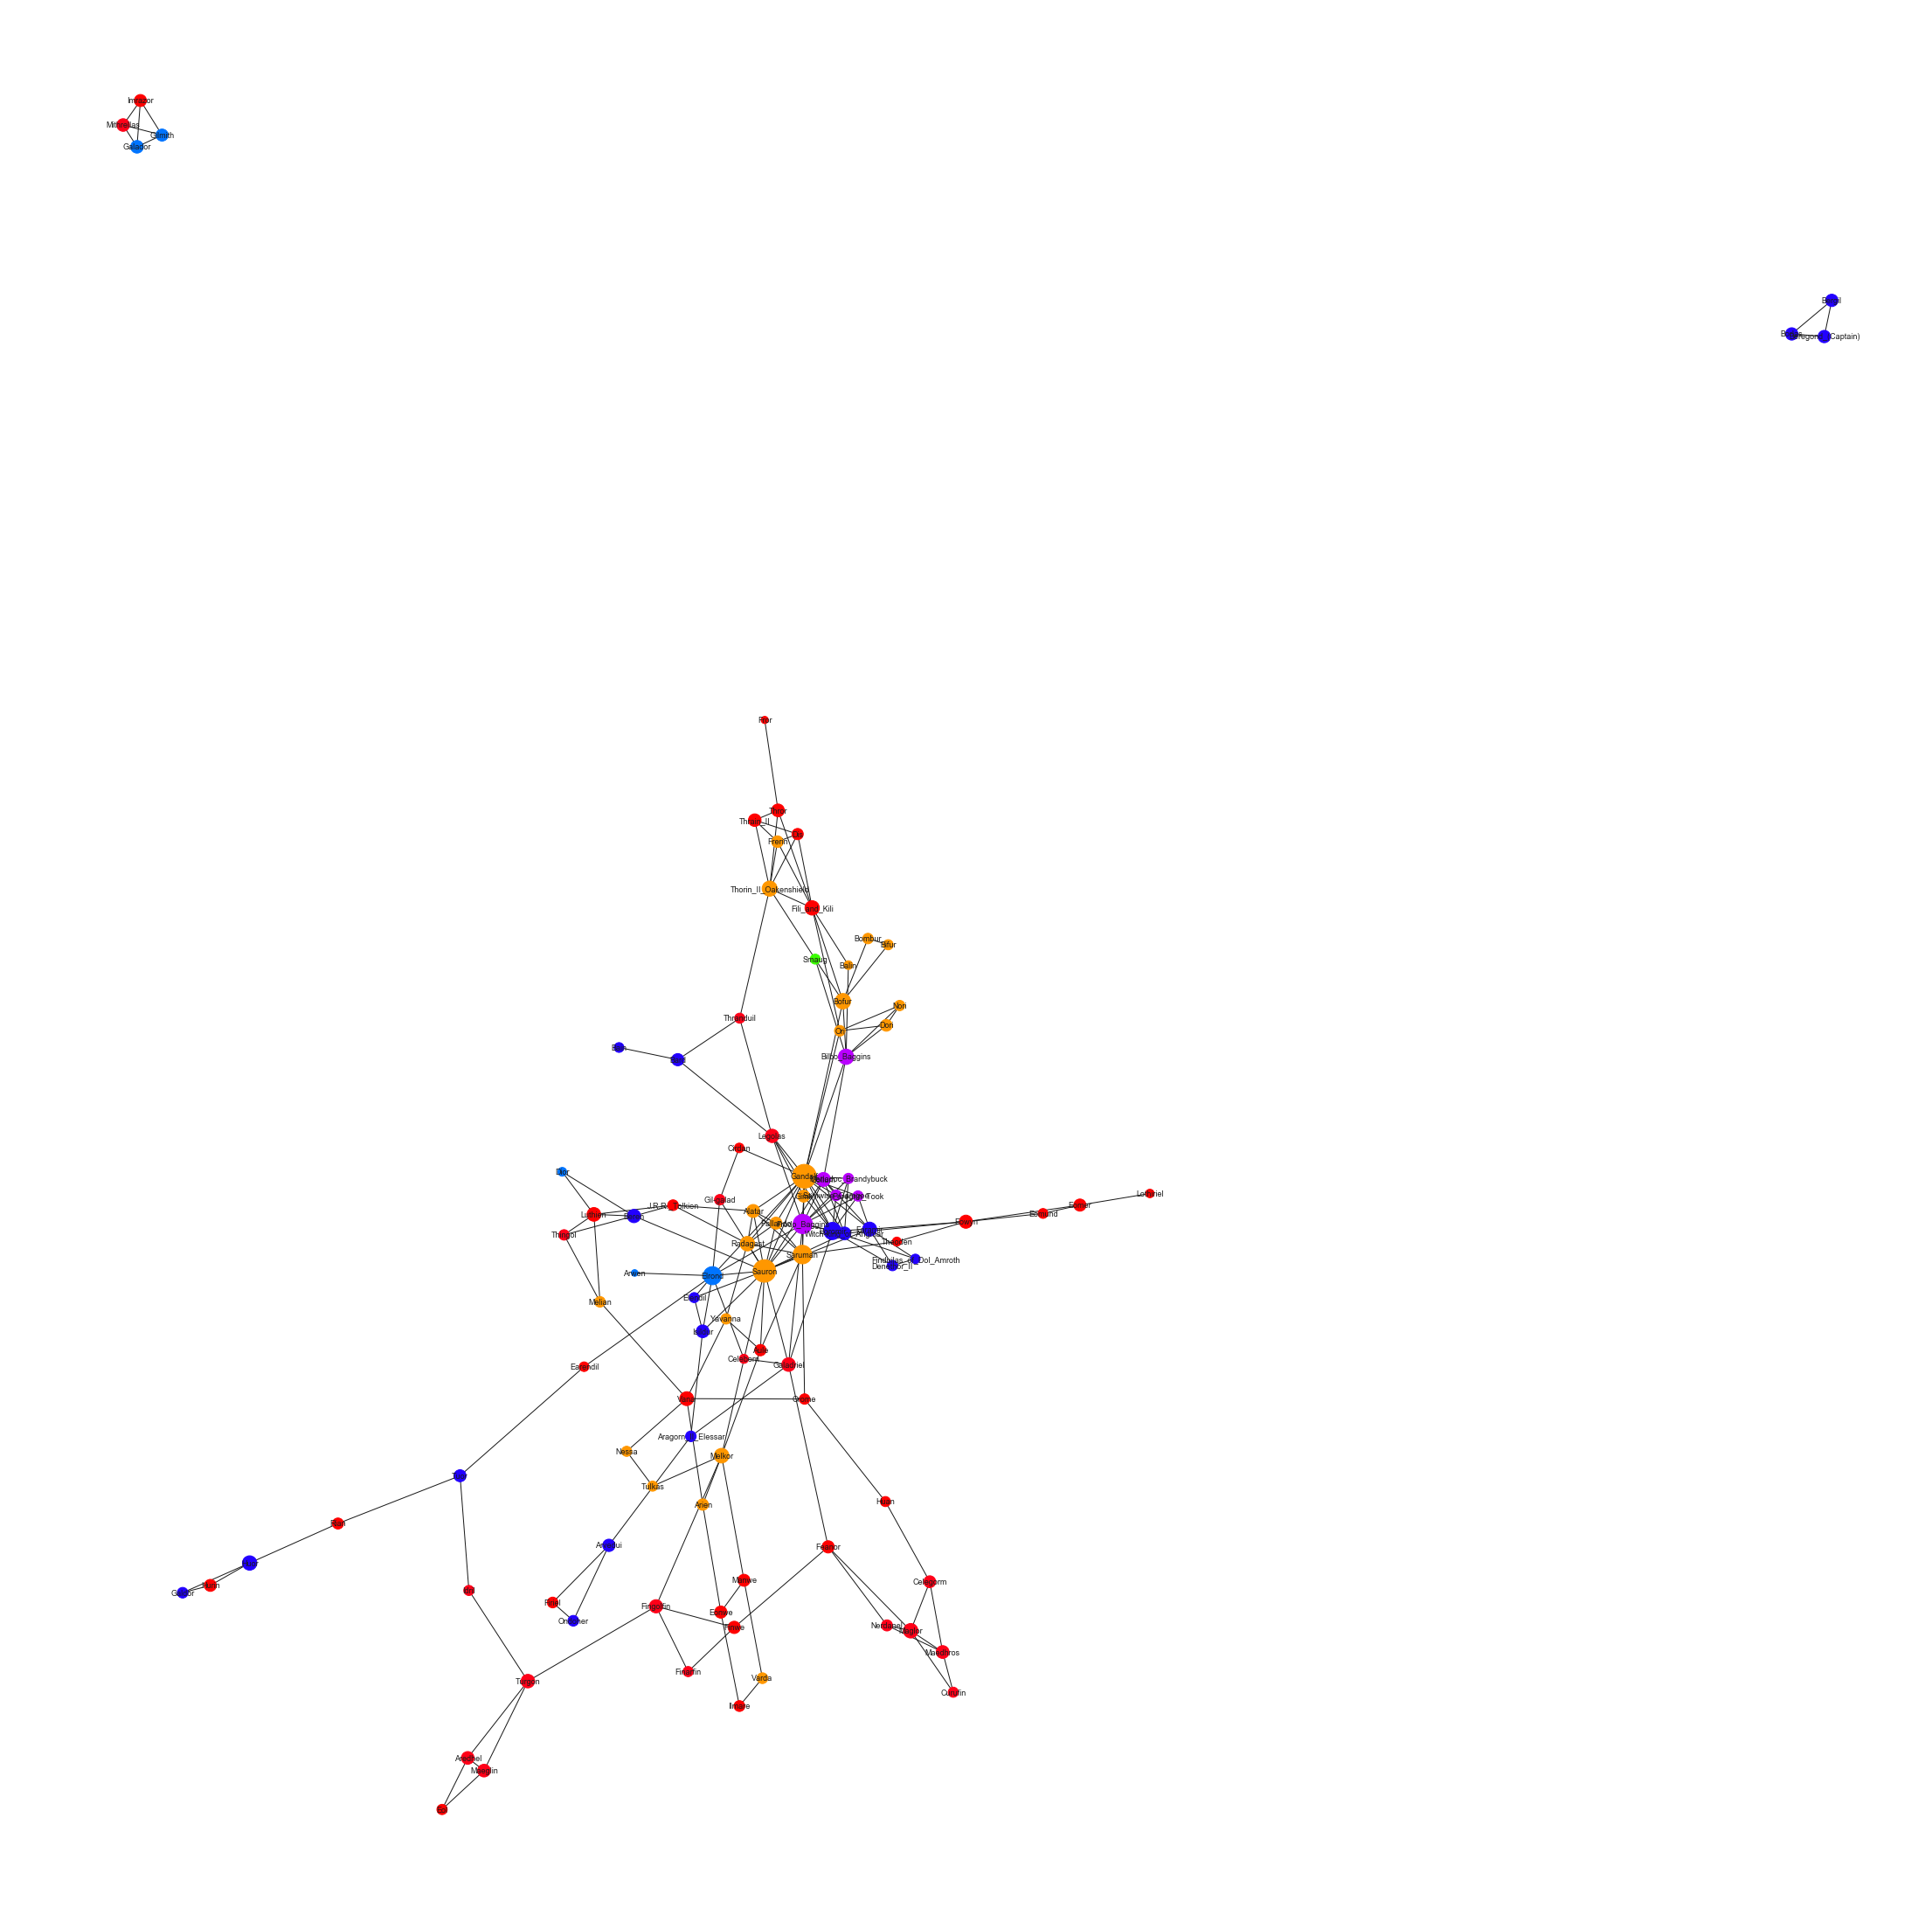

In [60]:
#The more central the node, the bigger its circle is. the nodes are colored according to their culture
import random
import matplotlib.pyplot as plt


node_pagerank = nx.algorithms.pagerank(subgraph)
node_sizes = []
for node in subgraph.nodes: 
    node_sizes.append(20000*node_pagerank[node])
node_colors = [None]*subgraph.number_of_nodes()
for i in range(len(node_colors)):
    if not node_colors[i]:
        node_colors[i]=(1.0, 0.0, 0.0, 1.0)
node_names = [node for node in subgraph.nodes]
for k, v in character_race.items():
    culture_color = colors(random.random()) #create color for culture
    for node in v:
        node_colors[node_names.index(node)] = culture_color
plt.figure(figsize=(30,30))
nx.draw(subgraph, pos=nx.spring_layout(subgraph),node_size=node_sizes,node_color=node_colors, with_labels = True, font_size = 9)
plt.show()

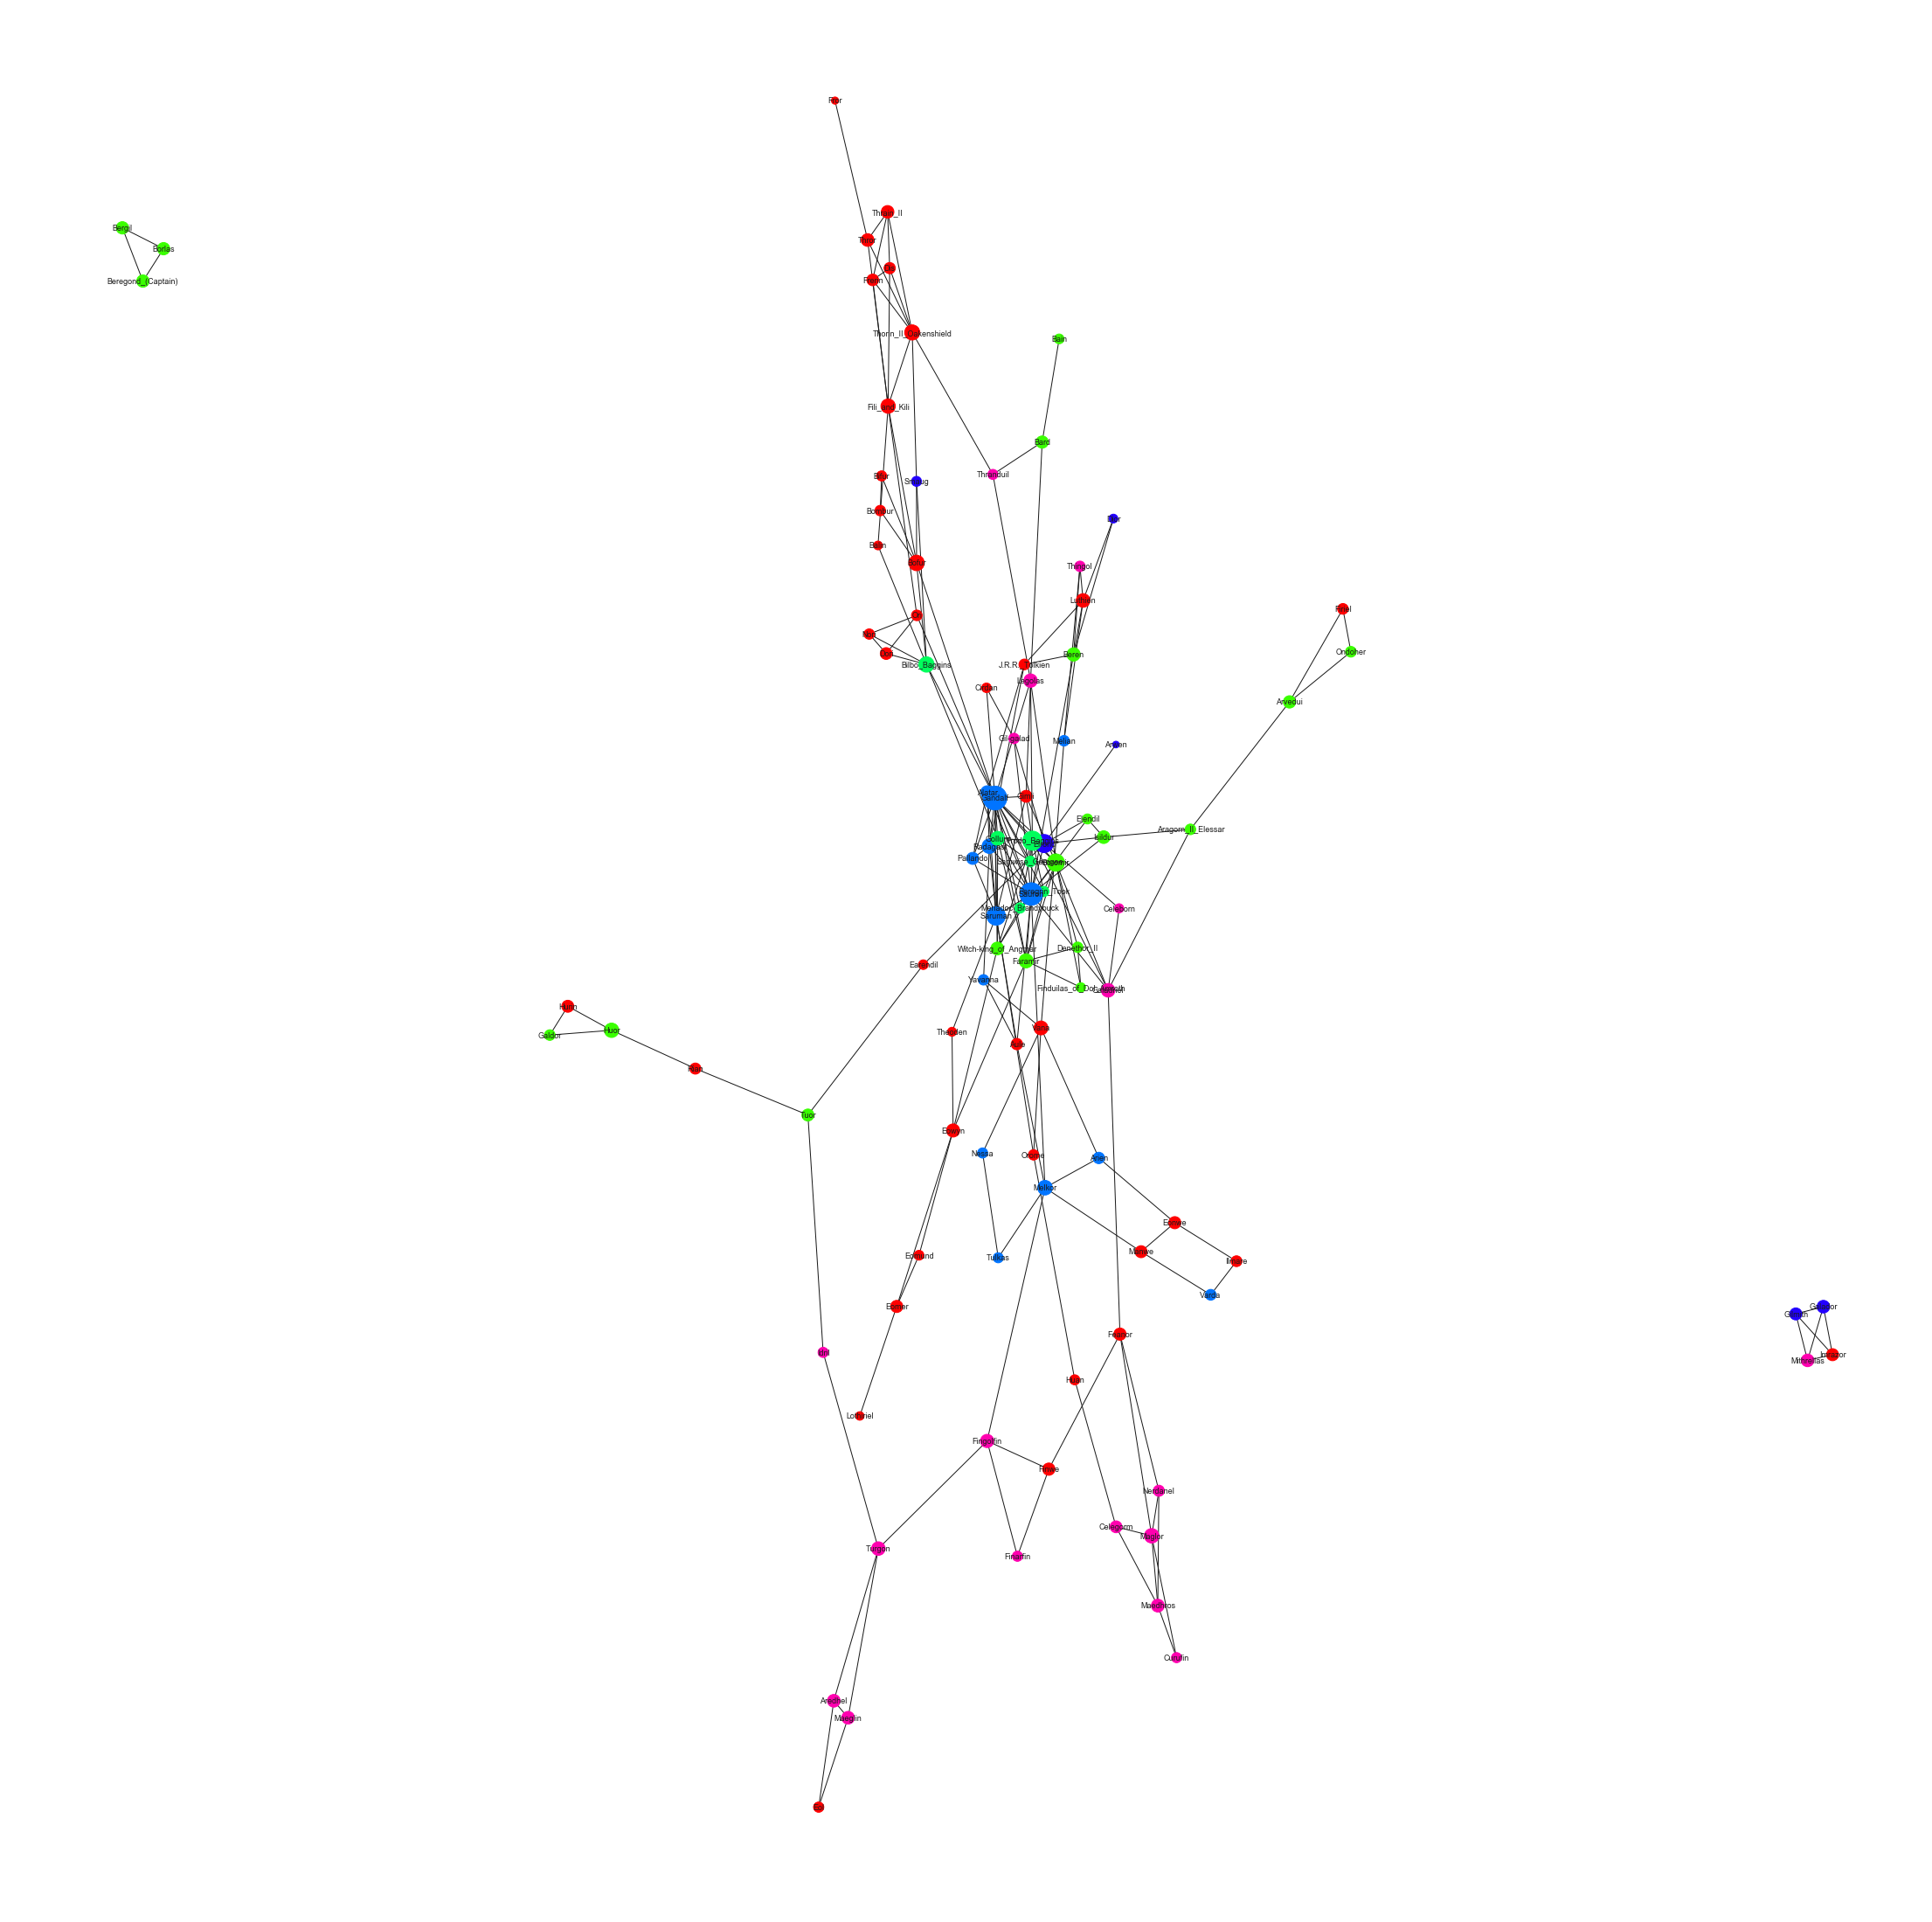

In [61]:

#The more central the node, the bigger its circle is. the nodes are colored according to their culture
import random
import matplotlib.pyplot as plt


node_pagerank = nx.algorithms.pagerank(subgraph)
node_sizes = []
for node in subgraph.nodes: 
    node_sizes.append(20000*node_pagerank[node])
node_colors = [None]*subgraph.number_of_nodes()
for i in range(len(node_colors)):
    if not node_colors[i]:
        node_colors[i]=(1.0, 0.0, 0.0, 1.0)
node_names = [node for node in subgraph.nodes]
for k, v in character_race.items():
    culture_color = colors(random.random()) #create color for culture
    for node in v:
        node_colors[node_names.index(node)] = culture_color
plt.figure(figsize=(30,30))
nx.draw(subgraph, pos=nx.spring_layout(subgraph),node_size=node_sizes,node_color=node_colors, with_labels = True, font_size = 9)
plt.show()

In [63]:
character_race = dict()
races_list=list(characters_details_df['race'].value_counts().head(11).index)
for race in races_list:
    temp_df = characters_details_df[['character_name','race']].groupby('race').get_group(race)
    character_race[race] = [i for i in list(temp_df.character_name) if i in list(subgraph.nodes)]
for k,v in character_race.items():
    if v==[]:
        del character_race[k]


In [65]:
race_colors = {'men':'#7A84DD','unknown':'#7A84DD', 'dwarves':"#B15B60", 'elves':'#8ACAE5', 'hobbits':'#BD9267', 'ents':'#F1A54D', 
               'orcs': "#020104",'ainur':'#3A7575',"half-elven":"#8ACAE5","ents":"#E3845D","dragons":"#F10301"
               ,"trolls":"#863E34"}

In [66]:
from networkx import nx
from pyvis.network import Network
from collections import OrderedDict
from unidecode import unidecode
import urllib
from networkx import nx


G = Network(height="800px", width="100%", bgcolor="#222222", font_color="white",notebook=True)

for character, weight in character_count.items():
    if weight > 15:
        character=unidecode(urllib.unquote_plus(character))
        if character in race_dict.keys():
            if race_dict[character] in race_colors.keys():
                color = race_colors[race_dict[character]]
            else:
                color = None
        else:
            color = None
        G.add_node(character,
                   title="",
                   weight=weight,
                   size=weight,
#                    size=1,
                   color=color,
                   label=character)

for character_net, weight in character_network.items():
    if weight >= 2:
        character_0=unidecode(urllib.unquote_plus(character_net[0]))
        character_1=unidecode(urllib.unquote_plus(character_net[1]))
        if character_0 in G.node_ids and character_1 in G.node_ids:

            G.add_edge(character_0,
                       character_1,
                       weight=weight,
                       title=character_0+' -> '+character_1+': '+str(weight)
                       ,width=1.5)

neighbor_map = G.get_adj_list()
for node in G.nodes:
    temp_df = characters_details_df[characters_details_df['normlized_name'] ==node["id"]].drop(['character_name',
                                                                                   'culture',
                                                                                   'weapon',
                                                                                   "normalized_realm",
                                                                                   "normlized_name"],axis=1)
    temp_df['graph_neighbors'] = ', '.join([str(elem) for elem in neighbor_map[node["id"]]]) 
    temp_df_name = temp_df['lotr_name']
    temp_df.drop(labels=['lotr_name'], axis=1,inplace = True)
    temp_df.insert(0, 'lotr_name', temp_df_name)
    temp_df = temp_df.T.dropna().rename({'normalized_culture': 'culture','normalized_weapon': "weapon","lotr_name":"name"})
    temp_df = temp_df.rename({0:''},axis=1)
    
    node["title"] += temp_df.to_html(header=False)
    node["value"] = len(neighbor_map[node["id"]])
G.barnes_hut(gravity=-5000, central_gravity=0, spring_length=200, spring_strength=0.009, damping=0.025, overlap=0)
G.show('lotr_network_graph.html')